In [1]:
# !git clone https://github.com/getchar49/deepspray.git

In [2]:
import numpy as np

def process_txt(path):
    """
    Read .txt annotation file and convert to Python nested list.
    :param path: Python str, path to the .txt annotation file.
    :return: Python list of [label: int, c1: int, c2: int, c3: int, c4: int]
    """
    with open(path, 'r') as f:
        file_input = f.read()
    f.close()
    boxes = file_input.split('\n')[:-1]
    boxes = [box.split() for box in boxes]
    boxes = [[eval(i) for i in box] for box in boxes]
    return boxes

In [3]:
def yolo_to_coco(image_size, boxes):
    """
    Convert bounding box from YOLO format to COCO format.
    :param image_size: (height, width, ...)
    :param boxes: numpy array of shape (N, M>=4) in YOLO format [x, y, w, h, ...] normalized.
    :return: numpy array of shape (N, M) in COCO format [x, y, w, h, ...] in actual image size.
    """
    if not isinstance(boxes, np.ndarray):
        boxes = np.array(boxes)
    H, W = image_size[:2]
    new_boxes = np.copy(boxes).astype(np.int32)
    new_boxes[:, 0] = (boxes[:, 0] * W)
    new_boxes[:, 1] = (boxes[:, 1] * H)
    new_boxes[:, 2] = (boxes[:, 2] * W)
    new_boxes[:, 3] = (boxes[:, 3] * H)
    return new_boxes

def xywh_to_xyxy(boxes):
    """
    Convert bounding boxes from [x, y, w, h, ...] format to [xmin , ymin, xmax, ymax, ...].
    :param boxes: boxes: numpy array of shape (N, M>=4).
    :return: numpy array of shape (N, M).
    """
    if not isinstance(boxes, np.ndarray):
        boxes = np.array(boxes)
    new_boxes = np.copy(boxes)
    new_boxes[:, 0] = boxes[:, 0] - boxes[:, 2] / 2     ##############
    new_boxes[:, 1] = boxes[:, 1] - boxes[:, 3] / 2     ##############
    new_boxes[:, 2] = boxes[:, 0] + boxes[:, 2] / 2     ##############
    new_boxes[:, 3] = boxes[:, 1] + boxes[:, 3] / 2     ##############
    return new_boxes


def xyxy_to_xywh(boxes):
    """
    Convert bounding boxes from [xmin , ymin, xmax, ymax, ...] format to [x, y, w, h, ...].
    :param boxes: boxes: numpy array of shape (N, M>=4).
    :return: numpy array of shape (N, M).
    """
    if not isinstance(boxes, np.ndarray):
        boxes = np.array(boxes)
    new_boxes = np.copy(boxes)
    new_boxes[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2
    new_boxes[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2
    new_boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    new_boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    return new_boxes

In [4]:
class_name = ['bag', 'lobe', 'Detached ligament', 'drop', 'Attached ligament']
colors = ['red', 'orange', 'deepskyblue', 'mediumseagreen', 'darkgoldenrod']

name_to_id_mapping = {name: id for id, name in enumerate(class_name)}
id_to_name_mapping = {id: name for id, name in enumerate(class_name)}
name_to_color_mapping = {name: color for name, color in zip(class_name, colors)}
id_to_color_mapping = {id: color for id, color in enumerate(colors)}

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def plot_image(image, cmap=None, **kwargs):
    """
    :param image: numpy array of shape (H, W, C) representing image in RGB color space.
    :param kwargs:
        boxes: numpy array - like of shape (N, 5) or (N, 6).
        font_size: int
        id_to_name_mapping: Python dictionary
        id_to_color_mapping: Python dictionary
        border_width: int
    :return:
    """
    # assert len(image.shape) == 3, f"Invalid shape for image, must be a 3-dim array, got {image.shape}"
    image = Image.fromarray(image)
    plotted_image = ImageDraw.Draw(image)

    if 'font_size' not in kwargs:
        kwargs['font_size'] = 9
    font = ImageFont.truetype('Arial.ttf', kwargs['font_size'])

    if 'border_width' not in kwargs:
        kwargs['border_width'] = 1

    if 'boxes' in kwargs:
        assert kwargs['boxes'].shape[1] in [4, 5, 6], f"Invalid box shape: must be (N, M) where M must be in (4, 5, 6), got {kwargs['boxes'].shape}"
        for box in kwargs['boxes']:
            if box.shape[-1] > 4:
                class_id = int(box[-1])
            else:
                class_id = None
            if 'id_to_color_mapping' in kwargs:
                color = kwargs['id_to_color_mapping'][class_id]
            else:
                color = 'red'

            x1, y1, x2, y2 = box[:4]
            plotted_image.rectangle(
                ((x1, y1), (x2, y2)),
                outline=color,
                width=kwargs['border_width']
            )

            if class_id is None: class_name = ''
            else:
                if 'id_to_name_mapping' in kwargs: class_name = kwargs['id_to_name_mapping'][class_id]
                else: class_name = str(class_id)

                msg = ' ' + class_name + (f': {box[-2]:.2f} ' if kwargs['boxes'].shape[-1] == 6 else ' ')

                text_w, text_h = font.getsize(msg)
                plotted_image.rectangle(((x1, y1 - text_h), (x1 + text_w, y1)), fill=color, outline=color)
                plotted_image.text((x1, y1 - text_h), msg, fill='white', font=font)

    plt.imshow(image, cmap=cmap)
    return np.array(image)

In [6]:
from pathlib import Path
from PIL import Image

# ### VISUALIZE temporarily commented
#
# for lbl_path in Path('deepspray/data/data_1/labels').glob('*'):
#     lbl_path = str(lbl_path)
#     img_path = lbl_path.replace('labels', 'images').replace('txt', 'png')
#
#     boxes = process_txt(lbl_path)
#     boxes = np.array([box[1:] + box[:1] for box in boxes])
#     img = Image.open(img_path).convert('RGB')
#     img = np.array(img)
#     boxes = yolo_to_coco(img.shape[:2], boxes)
#     boxes = xywh_to_xyxy(boxes)
#     print(lbl_path)
#     plt.figure(figsize=(40, 20))
#     plot_image(img, boxes=boxes, id_to_color_mapping=id_to_color_mapping, id_to_name_mapping=id_to_name_mapping)
#     # plt.show()          # uncomment this to show images
#
# ### END

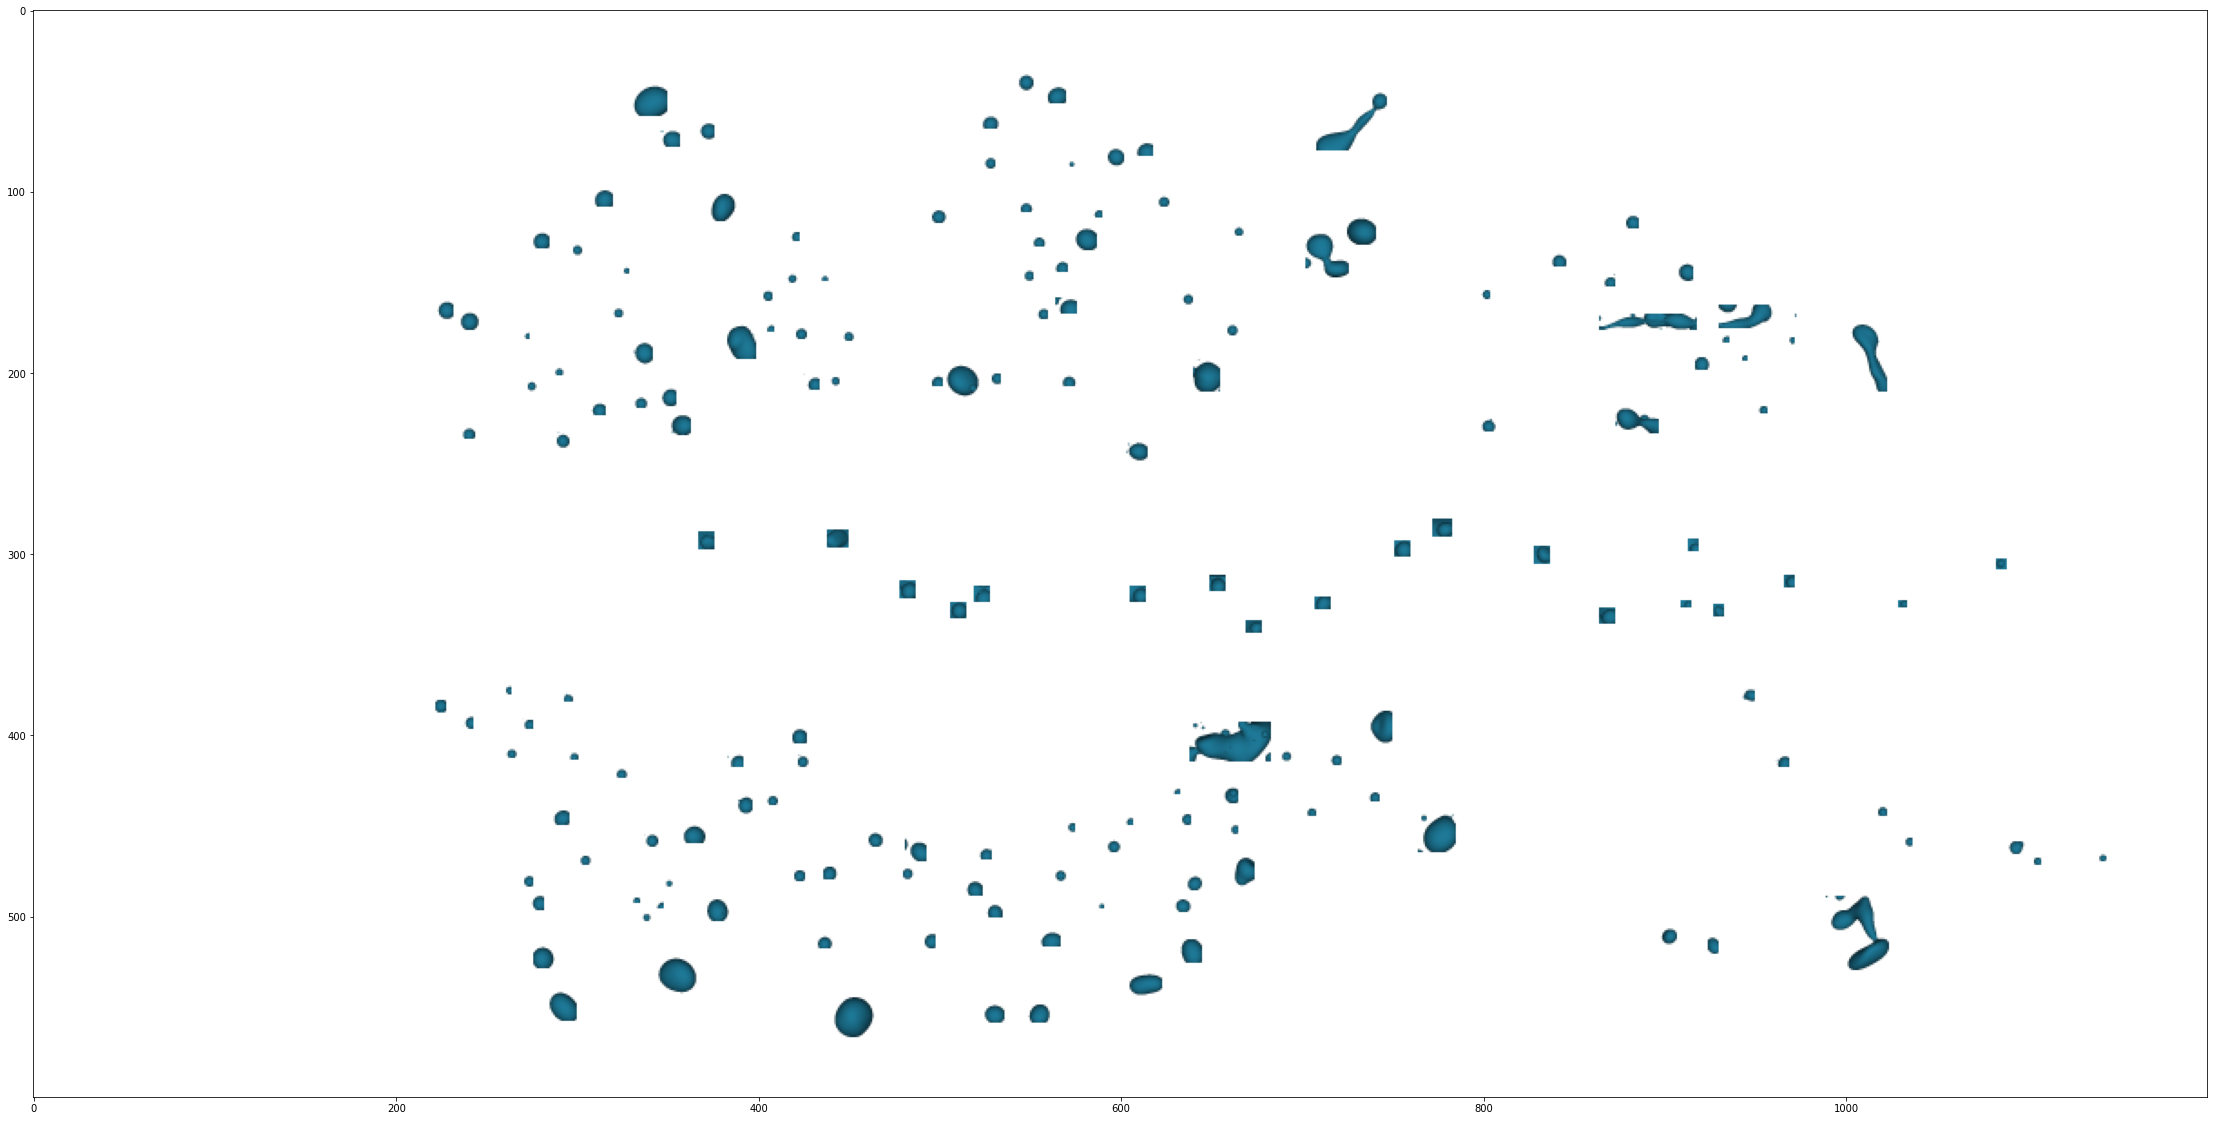

In [7]:
lbl_path = 'deepspray/data/data_1/labels/f_01495.txt'
img_path = lbl_path.replace('labels', 'images').replace('txt', 'png')

img = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
# thử paste ra ảnh trắng cùng kích thước
out_img = np.full_like(img, 255)

boxes = process_txt(lbl_path)
boxes = [box[1:] for box in boxes]
boxes = xywh_to_xyxy(yolo_to_coco(img.shape, boxes))

for box in boxes:   # box: [class_id, x, y, w, h]
    x1, y1, x2, y2 = box
    out_img[y1:y2, x1:x2] = img[y1:y2, x1:x2]

plt.figure(figsize=(40, 20))
plt.imshow(out_img)
plt.show()

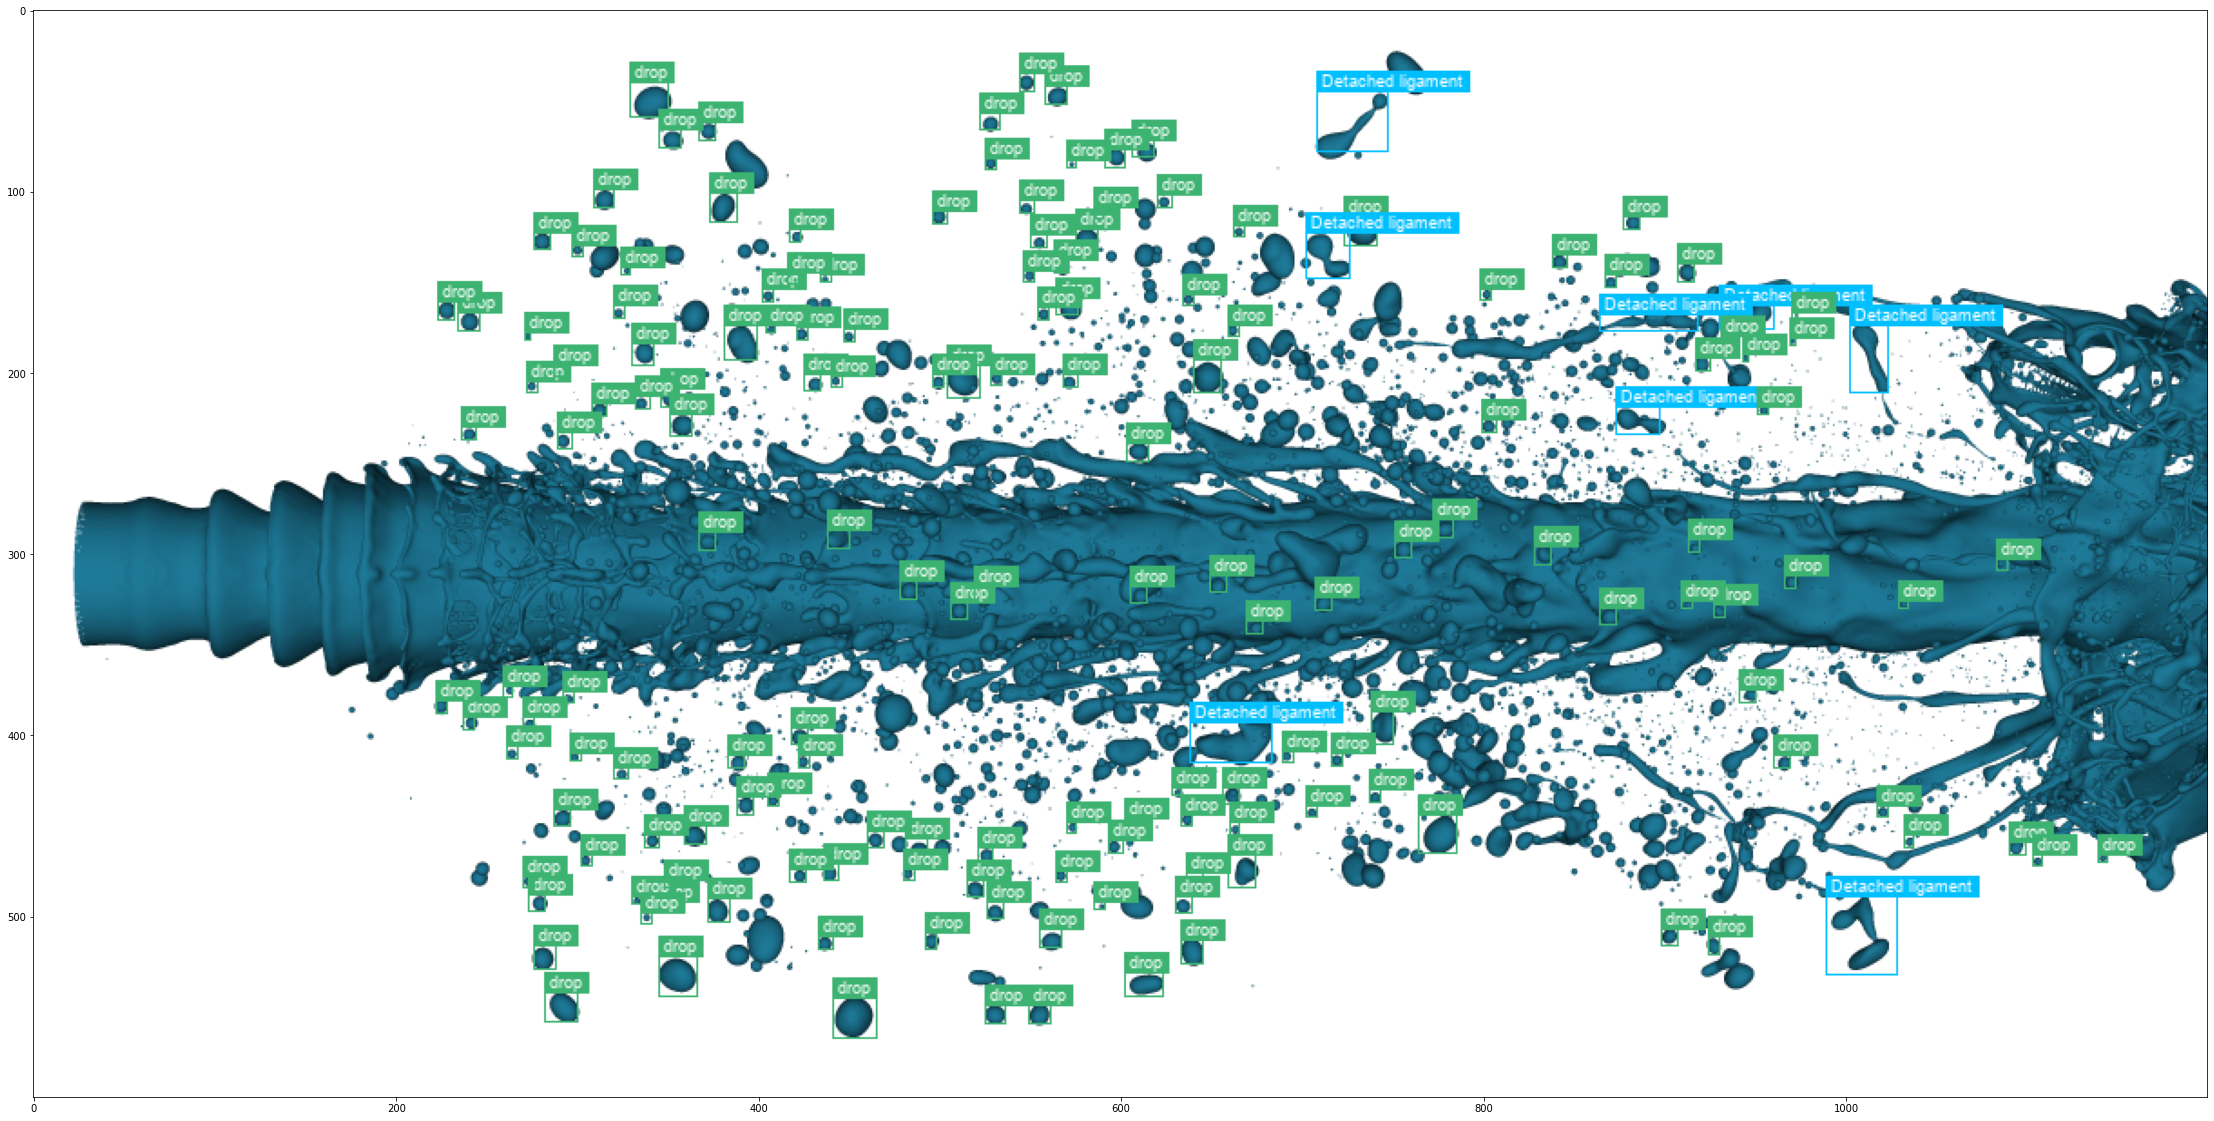

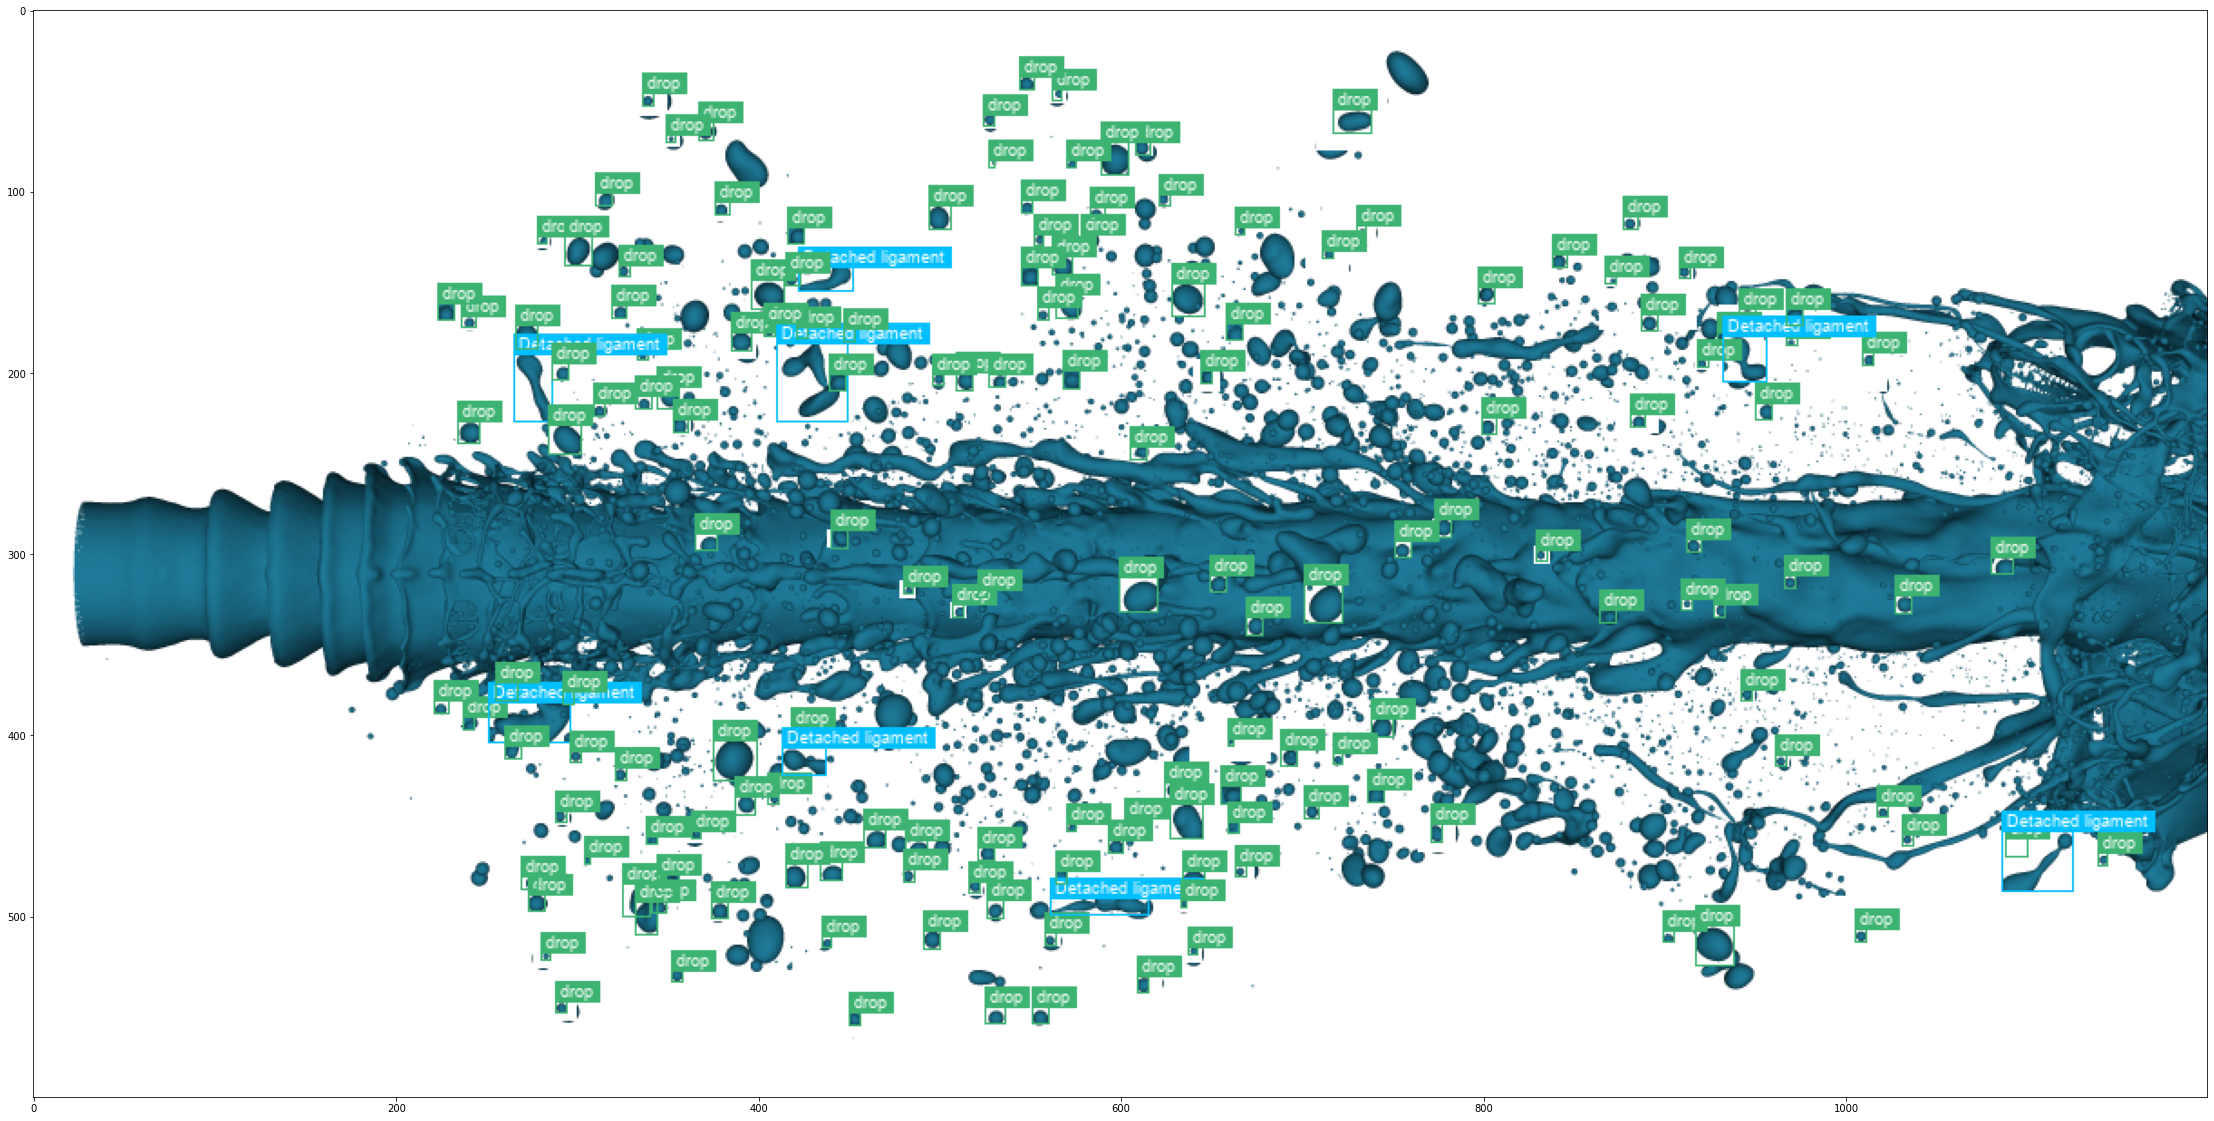

In [8]:
# augment đơn giản:
# dùng các box đã đánh nhãn thủ công (vẫn giữ background xung quanh, - xử lý sau), và dòng chính (vẫn giữ lại các giọt chưa gán nhãn - xử lí sau :D)
# đổi vị trí cho nhau
# thay đổi kích thước, nhưng trong giới hạn cho phép (cụ thể chưa biết)

img = np.array(Image.open(img_path).convert('RGB'))

boxes = process_txt(lbl_path)
boxes = [box[1:] + box[:1] for box in boxes]
boxes = xywh_to_xyxy(yolo_to_coco(img.shape, boxes))

def wipe(img, boxes):
    # cho ảnh và boxes của các giọt bắn trong ảnh.
    # tạm thời: đơn thuần xóa các boxes trong ảnh, để lại các khoảng trắng nhức mắt :-D
    assert len(boxes.shape) == 2, f"src_boxes must be a 2-D array. Got shape = {boxes.shape}"
    img = np.copy(img)
    for box in boxes:
        x1, y1, x2, y2 = box[:4]
        img[y1:y2, x1:x2] = 255
    return img

def get_drops(img, boxes):
    # tạm thời cắt lấy các boxes hình chữ nhật theo trục, sau này chỉnh lại cho các dạng khác
    drops = []
    for box in boxes:
        x1, y1, x2, y2 = box[:4]
        drops.append(img[y1:y2, x1:x2])
    return drops

def augment(src_img, src_boxes, des_img, des_boxes):
    # tạm thời des_boxes = None, des_img là ảnh trắng.
    # src_boxes: xyxy
    assert len(src_boxes.shape) == 2, f"src_boxes must be a 2-D array. Got shape = {src_boxes.shape}"

    # tính tâm của các boxes trên ảnh gốc
    # lặp lại để lát nữa tiện tính toán
    des_centers = xyxy_to_xywh(src_boxes)
    des_centers[:, 2:4] = des_centers[:, :2]

    # shuffle các box (chỉ quan tâm tới kích thước của box)
    # lát nữa sẽ dán các mẩu ảnh đã shuffle vào các tâm cũ
    src_boxes = np.random.permutation(src_boxes)
    src_centers = xyxy_to_xywh(src_boxes)
    src_centers[:, 2:4] = src_centers[:, :2]

    if src_centers.shape[-1] > 4:
        des_centers[:, 4:] = src_boxes[:, 4:]

    # tọa độ của các box mới bằng tọa độ các box cũ + độ xê dịch của tâm
    des_boxes = src_boxes + (des_centers - src_centers)

    des_img = np.copy(des_img)
    for des_box, src_box in zip(des_boxes, src_boxes):
        # dán các box mới vào vị tâm cũ
        dx1, dy1, dx2, dy2 = des_box[:4]
        sx1, sy1, sx2, sy2 = src_box[:4]
        des_img[dy1:dy2, dx1:dx2] = src_img[sy1:sy2, sx1:sx2]

    return des_img, des_boxes

plt.figure(figsize=(40, 20))
plot_image(img, boxes=boxes, id_to_color_mapping=id_to_color_mapping, id_to_name_mapping=id_to_name_mapping)
plt.show()

# # paste vào ảnh trắng
# des_img = np.full_like(img, 255)
# des_img, des_boxes = augment(img, boxes, des_img, None)

# paste vào chính ảnh gốc (thay đổi vị trí các giọt)
des_img = wipe(img, boxes)
des_img, des_boxes = augment(img, boxes, des_img, None)
plt.figure(figsize=(40, 20))
plot_image(des_img, boxes=des_boxes, id_to_name_mapping=id_to_name_mapping, id_to_color_mapping=id_to_color_mapping)
plt.show()

Contour [2.2.1]

In [34]:
# 2.2.1. Contour > Đưa về ảnh nhị phân
import cv2
import os

os.makedirs('1', exist_ok=True)

img_path = 'data/f_01572.png'

img = cv2.imread(img_path)
cv2.imwrite('1/img.png', img)

# chuyển ảnh về gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_gray.png', img_gray)

# tạo mask chỉ lấy vật thể
img_mask = np.full_like(img_gray, 255)
img_mask[np.where(img_gray == 255)] = 0
cv2.imwrite('1/img_mask.png', img_mask)

# # global threshold: README
# ret, thresh = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)
# cv2.imwrite('1/thresh.png', thresh)

True

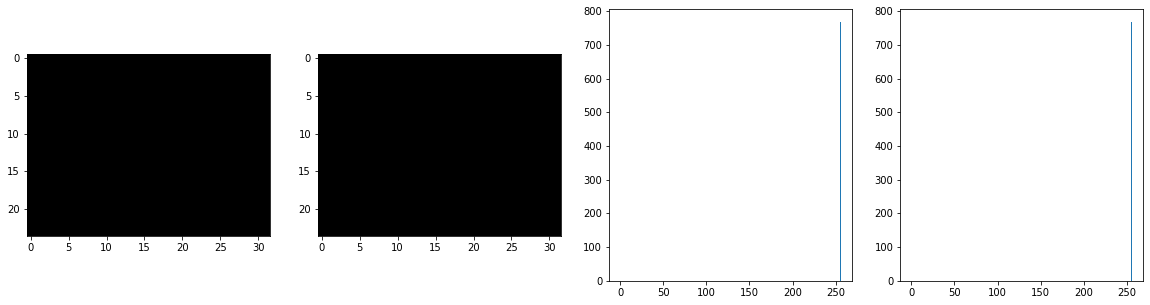

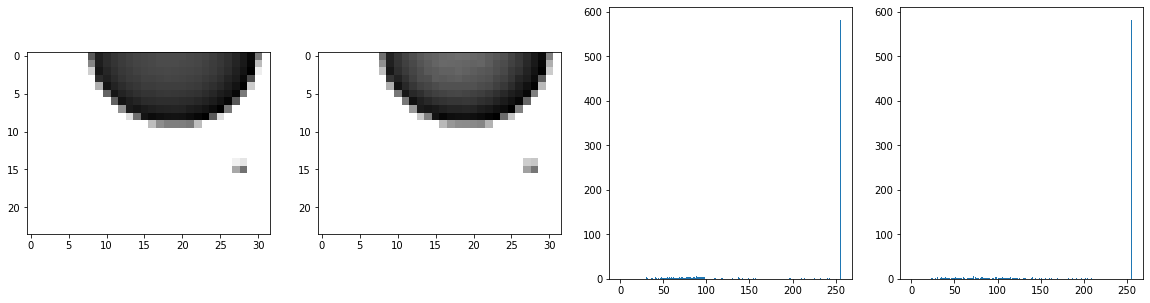

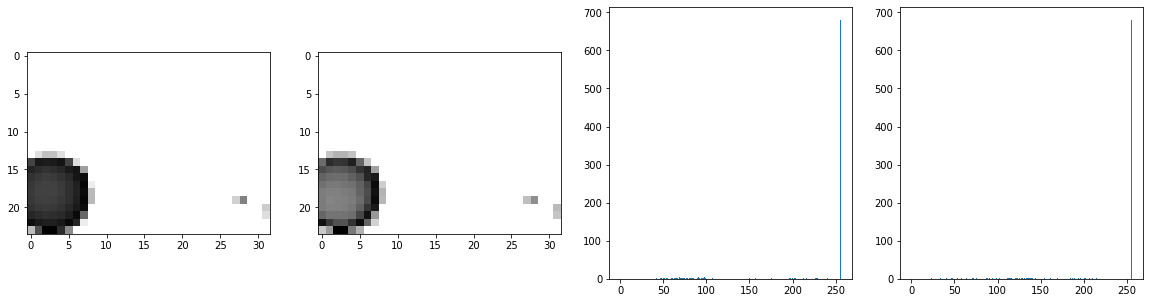

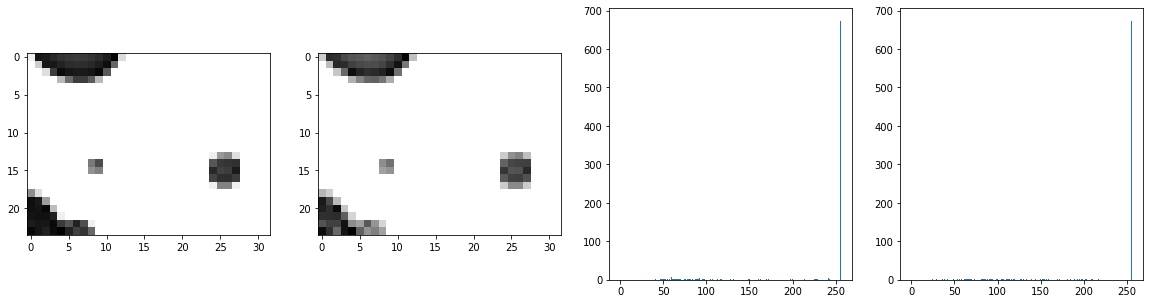

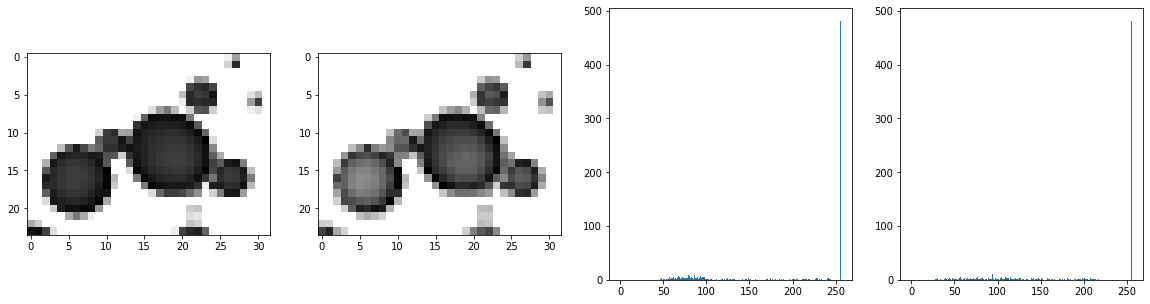

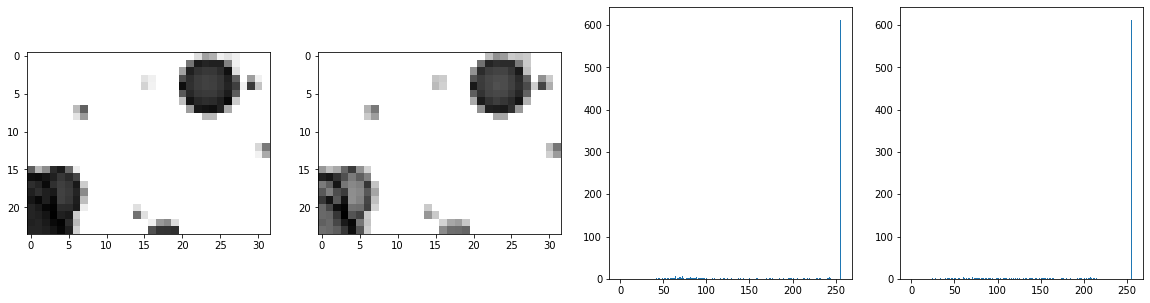

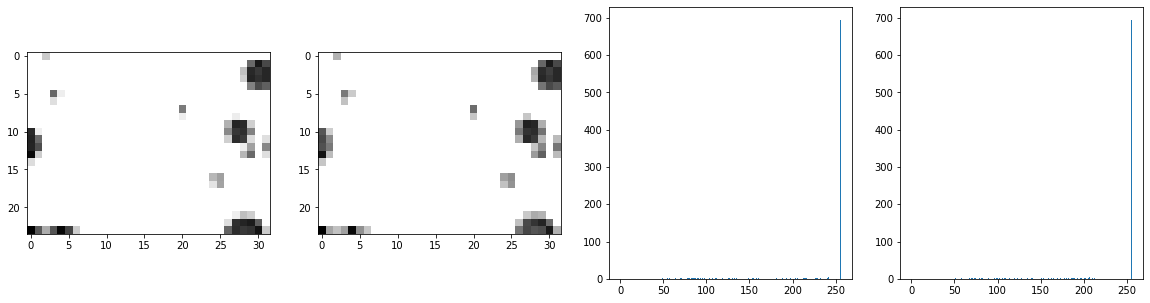

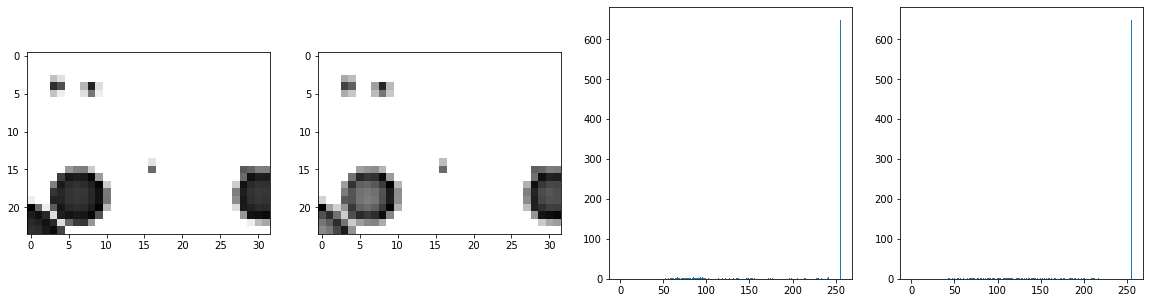

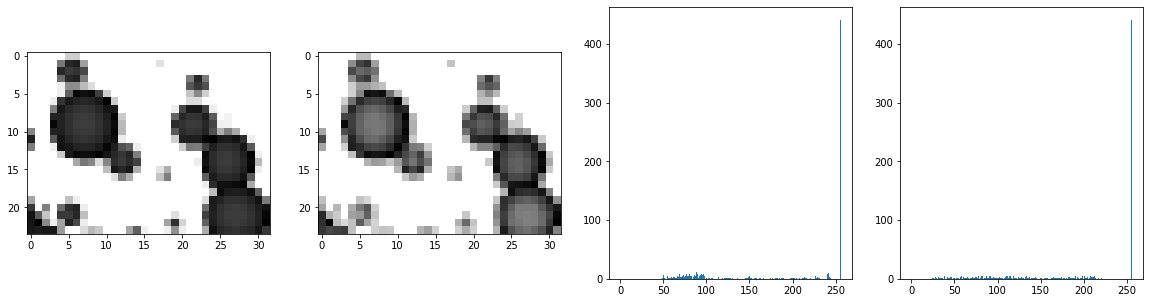

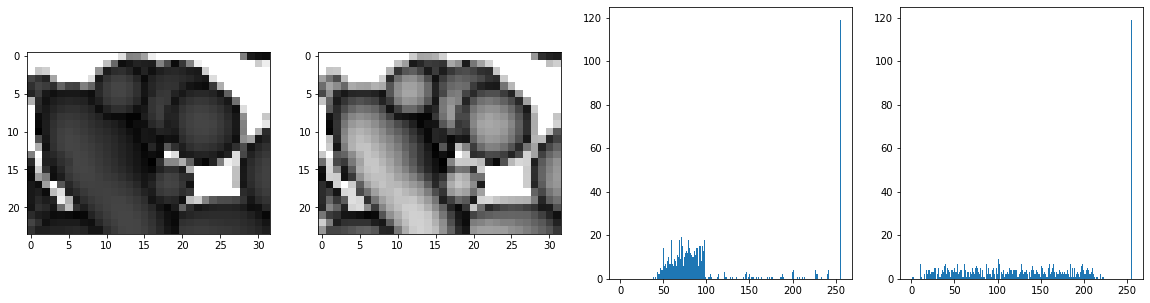

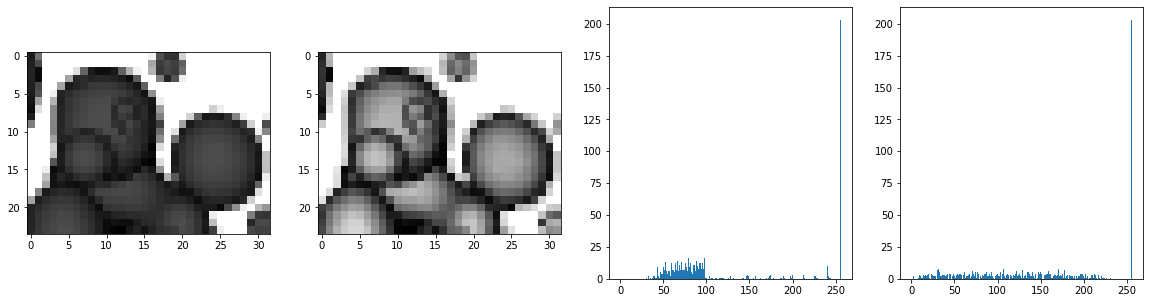

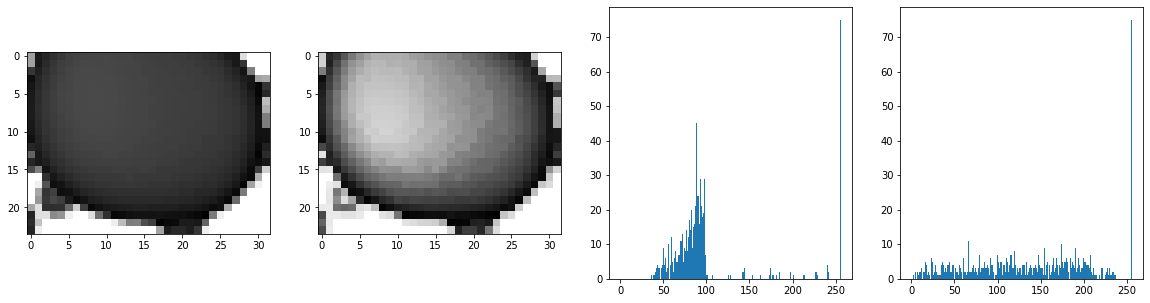

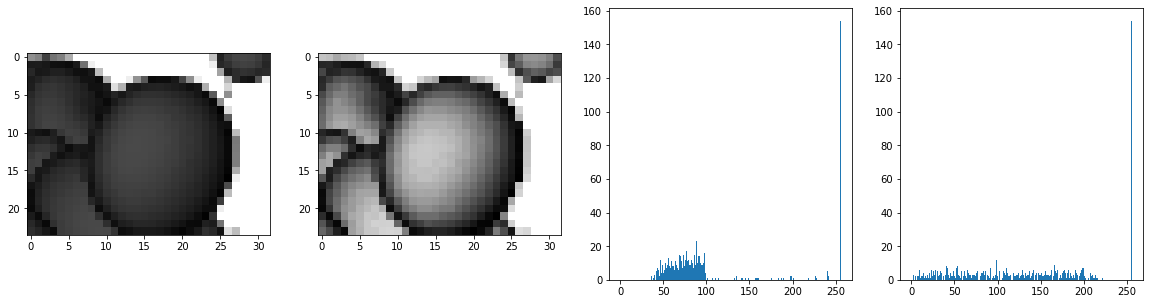

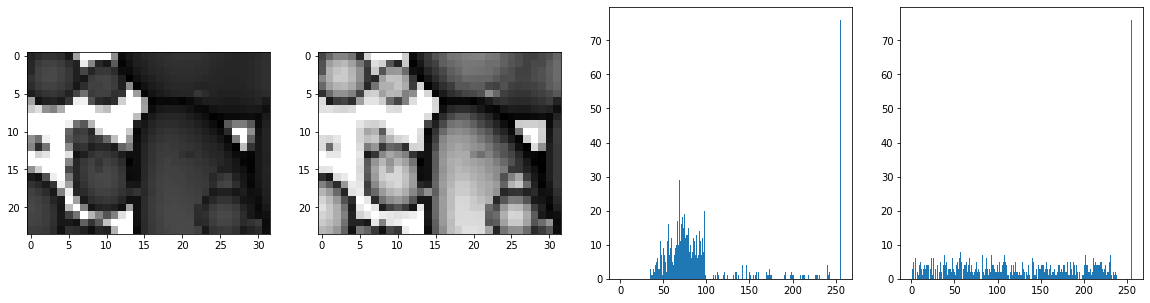

In [31]:
# Hướng 1: dùng CLAHE trên ảnh (BỎ)

### tham số cần chỉnh
clipLimit = 40.0
nrow, ncol = (50, 50)

clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(nrow, ncol))

img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
img_hls[:, :, 1] = clahe.apply(img_hls[:, :, 1])
img_clahe = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
cv2.imwrite('1/img_clahe.png', img_clahe)

img_clahe_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_clahe_gray.png', img_clahe_gray)

tileH, tileW = img.shape[0] // nrow, img.shape[1] // ncol
max_plot = 0
for i in range(4, nrow):
    j = i + 3
    patch = img_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
    patch_clahe = img_clahe_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1); plt.imshow(patch, cmap='gray')
    plt.subplot(1, 4, 2); plt.imshow(patch_clahe, cmap='gray')
    plt.subplot(1, 4, 3); plt.hist(patch.ravel(), 256, [0, 256])
    plt.subplot(1, 4, 4); plt.hist(patch_clahe.ravel(), 256, [0, 256])
    plt.show()
    max_plot += 1
    if max_plot == 14:
        break


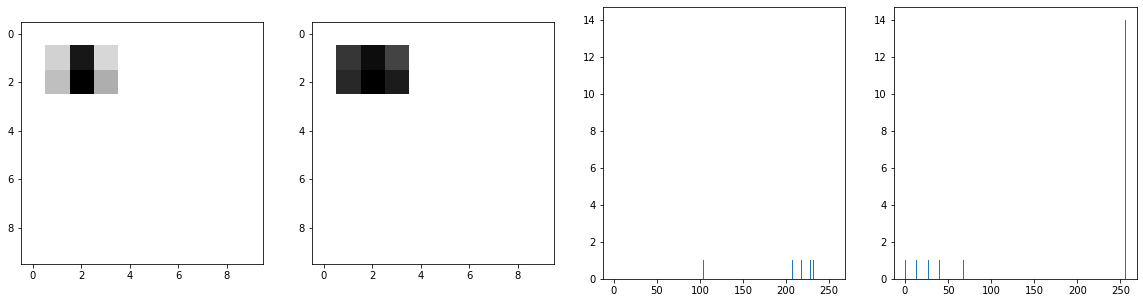

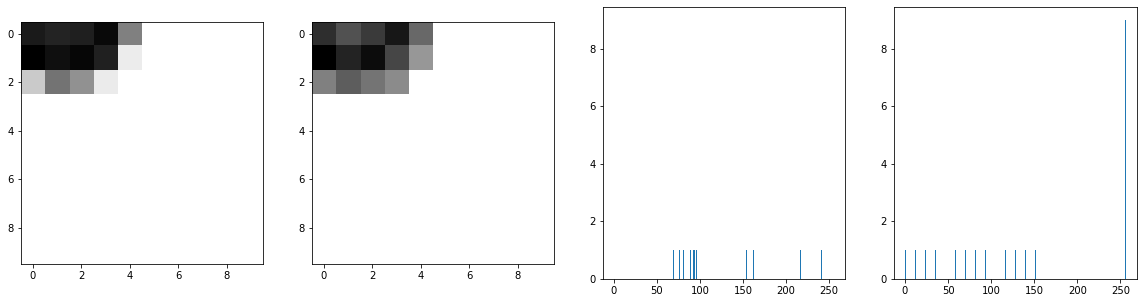

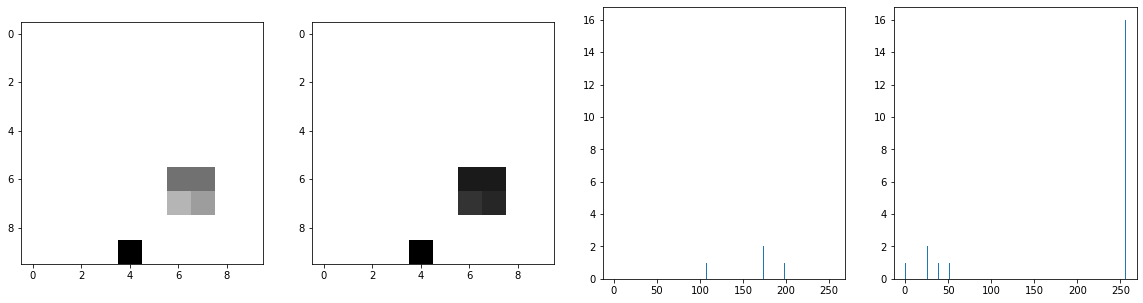

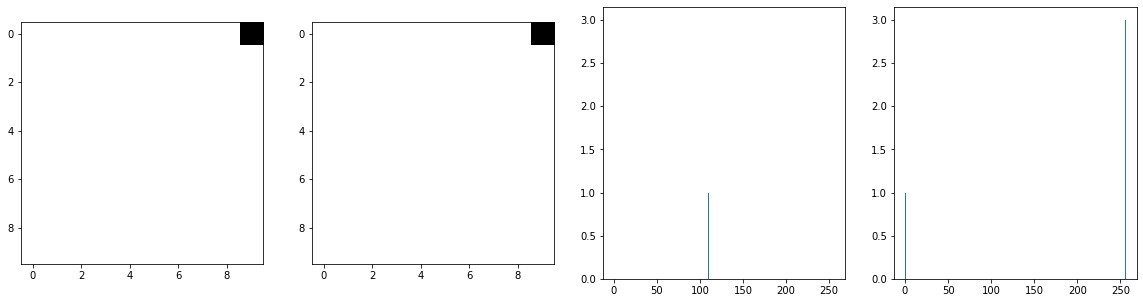

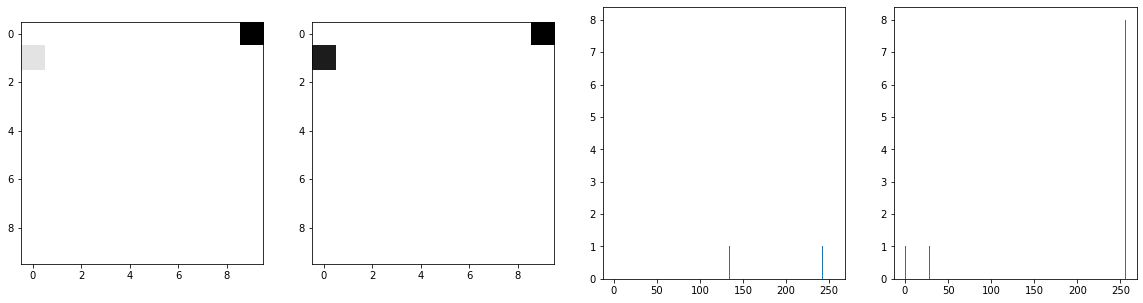

True

In [64]:
# Hướng 2: Dùng CLAHE, nhưng chỉ áp dụng cho phần màu xanh (dùng mask, có thể dilate) => hình cho ra tệ quá (BỎ)

### tham số cần chỉnh
nrow, ncol = (120, 160)

img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

tileH, tileW = img.shape[0] // nrow, img.shape[1] // ncol
max_plot = 0
for i in range(nrow):
    for j in range(ncol):
        patch = img_gray[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
        patch_mask = img_mask[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1)]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        patch_mask = cv2.dilate(patch_mask, kernel, iterations=1)

        loc = np.where(patch_mask == 255)
        if loc[0].shape[0] < 24:
            val = patch[loc]
            val = cv2.equalizeHist(val)
            patch_he = patch.copy()
            for k, l in enumerate(zip(loc[0], loc[1])):
                patch_he[l[0], l[1]] = val[k][0]

            img_hls[tileH * i: tileH * (i + 1), tileW * j: tileW * (j + 1), 1] = patch_he

            ### CHỈ ĐỂ VISUALIZE
            if loc[0].shape[0] > 0 and max_plot < 14:
                if j == i + 3:
                    plt.figure(figsize=(20, 5))
                    plt.subplot(1, 4, 1); plt.imshow(patch, cmap='gray')
                    plt.subplot(1, 4, 2); plt.imshow(patch_he, cmap='gray')
                    plt.subplot(1, 4, 3); plt.hist(patch[loc], 256, [0, 256])
                    plt.subplot(1, 4, 4); plt.hist(patch_he[loc], 256, [0, 256])
                    plt.show()
                    max_plot += 1
            ### HẾT

img_clahe = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
cv2.imwrite('1/img_clahe.png', img_clahe)

img_clahe_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_clahe_gray.png', img_clahe_gray)

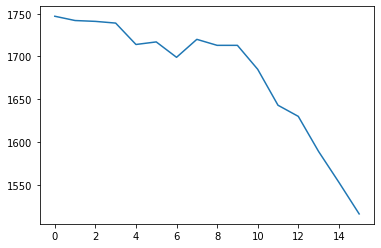

In [70]:
# Hướng 3: Không dùng CLAHE nữa, mà equalizeHist trên thành phần liên thông (BỎ)

nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask, connectivity=4)
img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
for k in range(1, nLabels):
    loc = np.where(labels == k)
    val = img_gray[loc]
    val = cv2.equalizeHist(val)
    for i, l in enumerate(zip(loc[0], loc[1])):
        img_hls[l[0], l[1], 1] = val[i][0]

img_he = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
cv2.imwrite('1/img_he.png', img_he)

img_he_gray = cv2.cvtColor(img_he, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_he_gray.png', img_he_gray)

temp = []
for thresh in range(240, 256):
    img_he_mask = np.full_like(img_he_gray, 255)
    img_he_mask[np.where(img_he_gray >= thresh)] = 0
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_he_mask, connectivity=4)
    temp.append(nLabels)
    cv2.imwrite(f'1/img_he_mask{thresh}.png', img_he_mask)
plt.plot(temp)
plt.show()


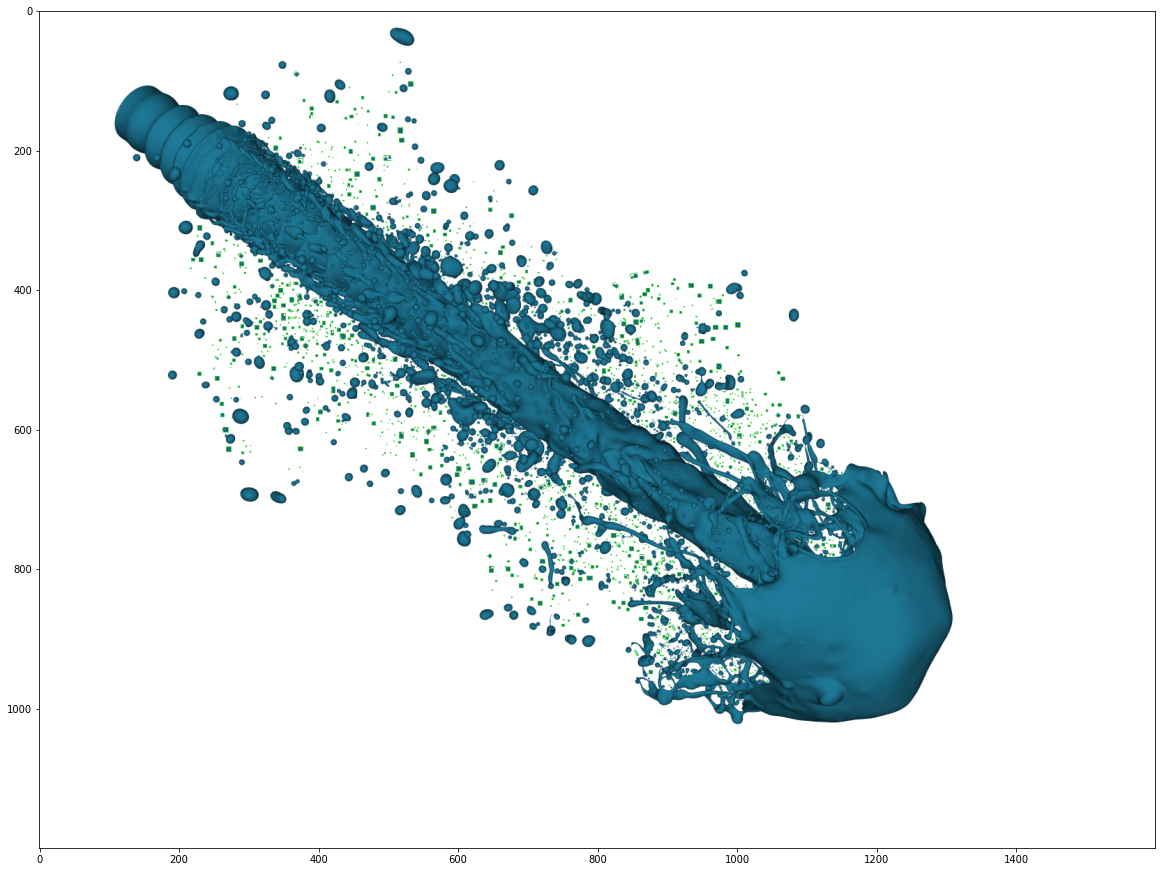

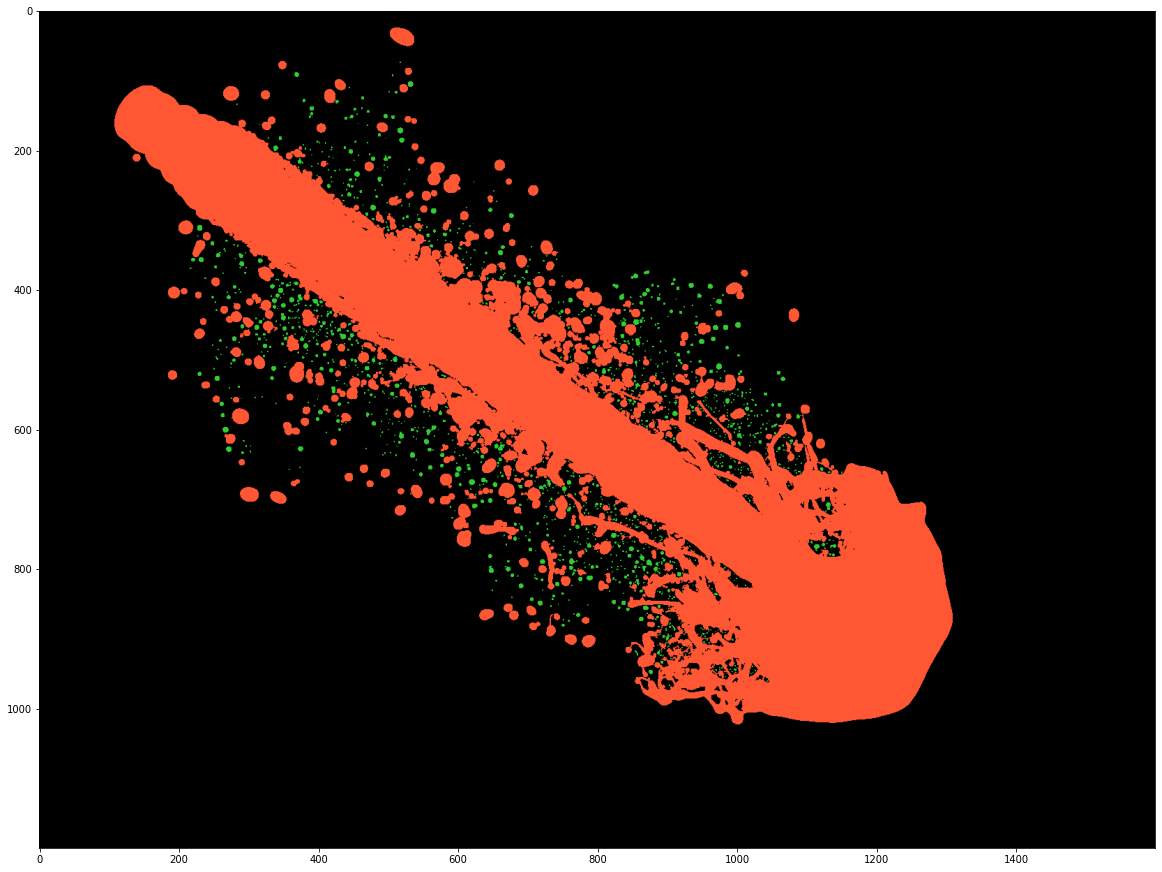

In [69]:
# Hướng 4: Không dùng CLAHE hay HE vội nữa, mà lọc lấy giọt bé bằng thành phần liên thông luôn (OK)

img_path = 'data/f_01572.png'

img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_mask = np.full_like(img_gray, 255)
img_mask[np.where(img_gray == 255)] = 0


# mục tiêu: dọn dẹp để sinh dữ liệu cho DL:
# giả sử kích thước của cc trải dài:
# ****************************
# -----------                         A phần mà CV bắt được
#       ----------------------        B phần mà DL sẽ huấn luyện trên nó
#      60
# A ^ B là phần giọt mà DL có thể bắt được, và CÓ THỂ sẽ chỉ dùng CV để bắt để phục vụ cho quá trình sinh dữ liệu (trường hợp nó dính nhau mà CV ko thể nhận biết được) cho DL, sau khi DL train xong thì CÓ THỂ sẽ tin tưởng DL hơn. CV khi lọc để sinh thì không cần bắt hết, Precision >> Recall
# A - (A ^ B): phần mà DL chắc chắn không bắt được
#

########### hình như dùng cc thì không bị nối đỉnh như contour thì phải => làm thí nghiệm xem sao :)))
#           tuy nhiên vẫn có lỗi ở trường hợp 2 giọt 2x2 nối với nhau theo đúng 1 cạnh

# Tìm thành phần liên thông trên mask
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask, connectivity=4)

YELLOW = (0, 195, 255)
RED = (51, 87, 255)
GREEN = (50, 205, 50)
BLUE = (255, 249, 126)
PURPLE = (255, 0, 170)

# Lưu lại box của các drop, tạo mask mới cho những thứ còn lại
points = []
class_name = []

### chỉ để visualize
vis_box = img.copy()
vis_seg = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR); vis_seg[img_mask == 255] = RED
###

for k in range(1, retval):
    size = stats[k, cv2.CC_STAT_AREA]
    if size < 60:
        loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1, 2)
        points.append(points)
        class_name.append('small drop')

        # sau khi đánh nhãn xong thì xóa đi
        img[labels == k] = 255
        img_gray[labels == k] = 255
        img_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, GREEN, 1)
        vis_seg[labels == k] = GREEN
        ###

### chỉ để visualize
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
plt.show()
###

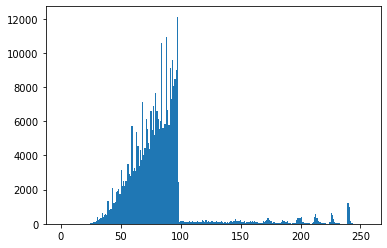

In [70]:
# Loại bỏ viền trước khi lọc tiếp => Hay, phải đem ra
# hỏi thầy xem có cách nào tự động tìm ra điểm này không?

plt.hist(img_gray.ravel(), 255, [0, 254])
plt.show()
loc = np.where(img_gray > 100)

img[loc] = 255
img_gray[loc] = 255
img_mask[loc] = 0

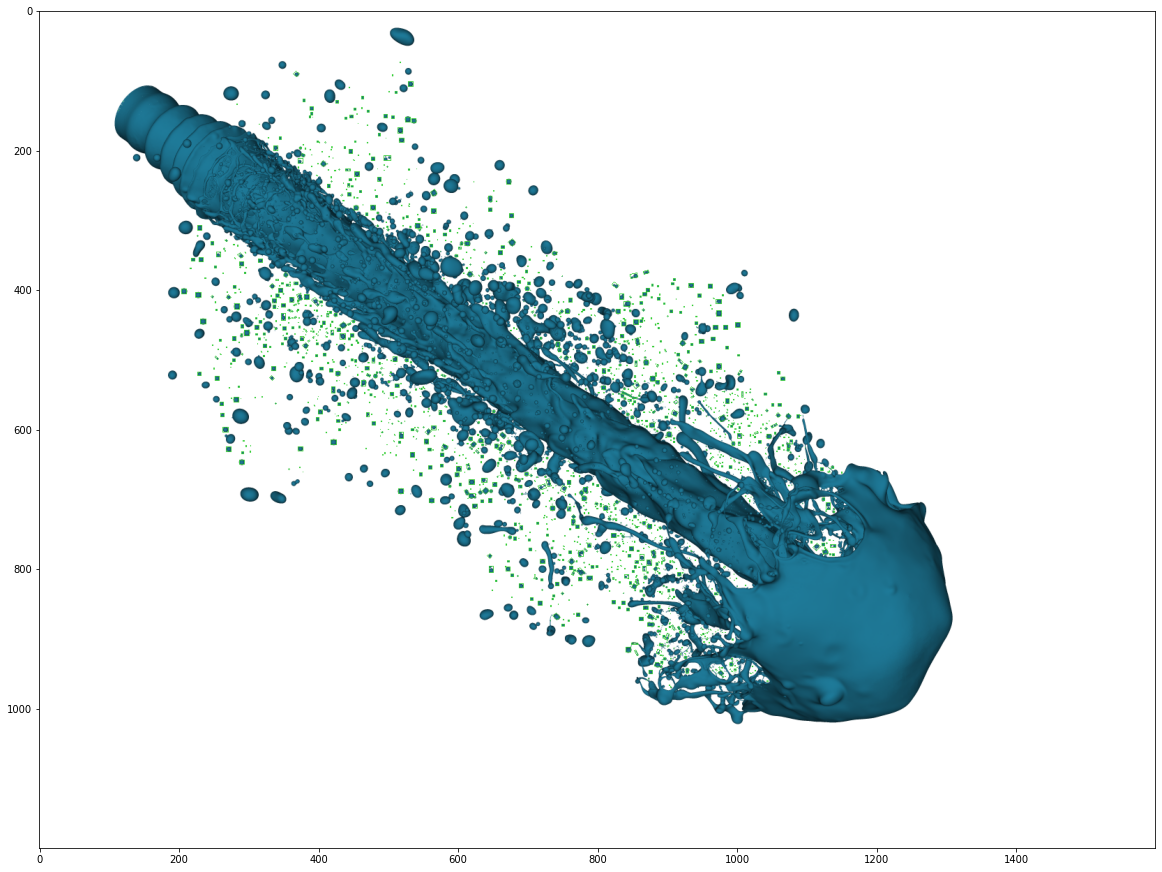

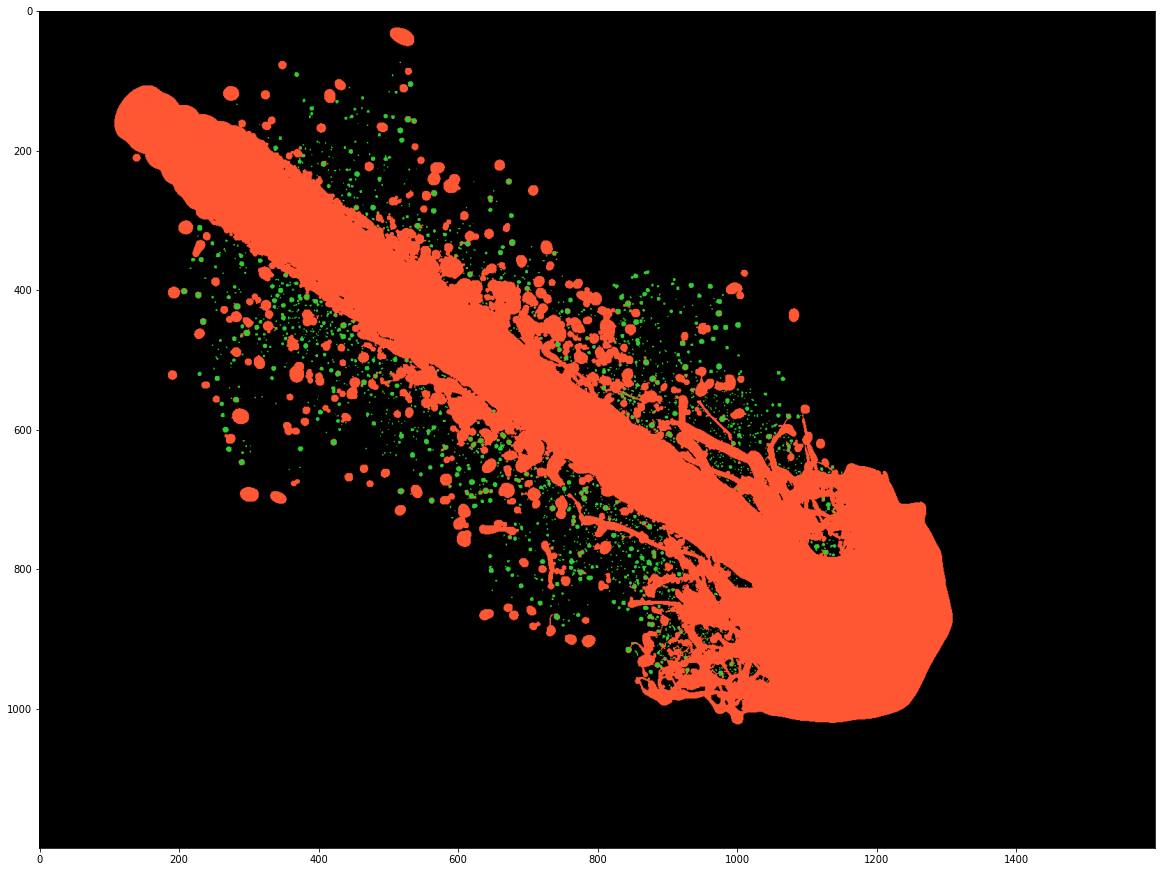

In [71]:
# Lọc tiếp lần nữa, y hệt bước trên, do sau khi bỏ viền sẽ có một số giọt tách ra

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask, connectivity=4)

for k in range(1, retval):
    size = stats[k, cv2.CC_STAT_AREA]
    if size < 60:
        loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1, 2)
        points.append(loc)
        class_name.append('small drop')

        # sau khi đánh nhãn xong thì xóa đi
        img[labels == k] = 255
        img_gray[labels == k] = 255
        img_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, GREEN, 1)
        vis_seg[labels == k] = GREEN
        ###


### chỉ để visualize
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
plt.show()
###

In [46]:
# lọc lấy phần chung: (BỎ vì không biết phải dùng cái nào cho tốt => phải có kết quả thực nghiệm mới được)
# hướng 1: dùng matchshape


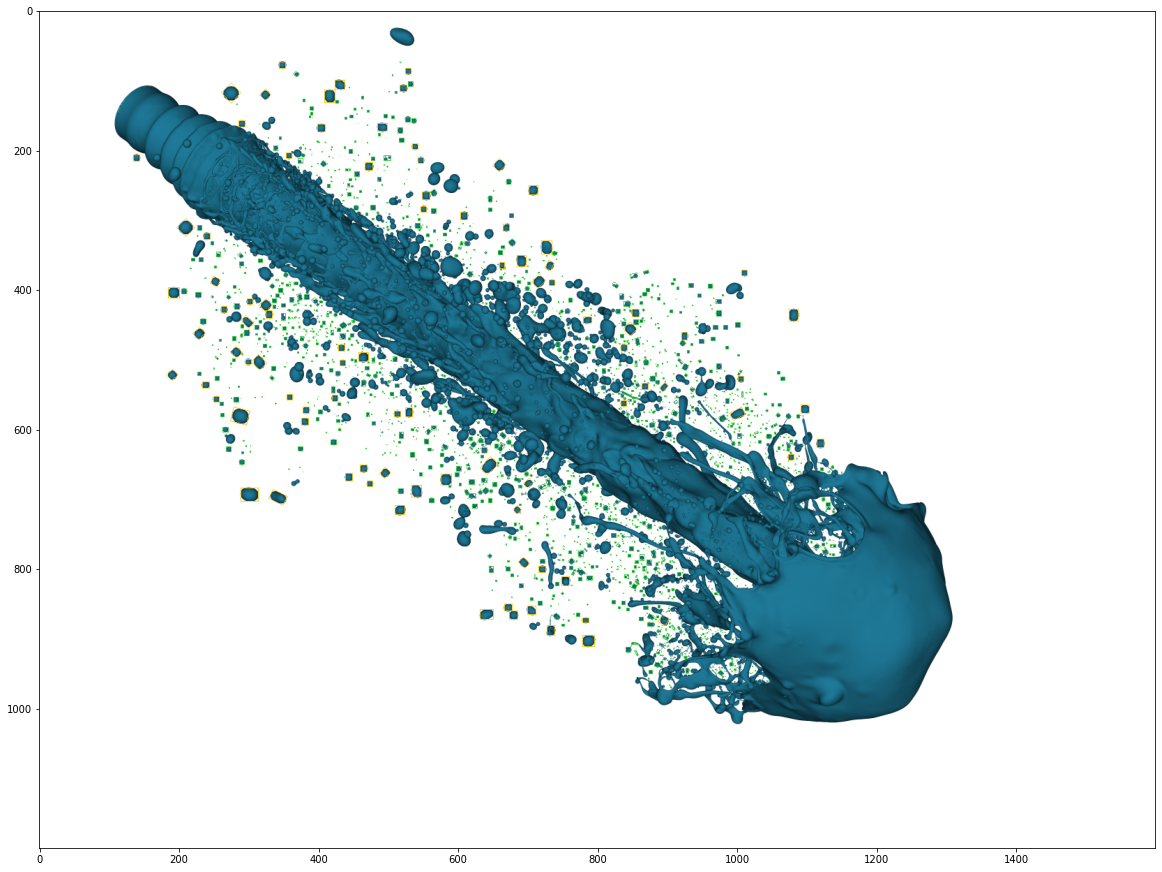

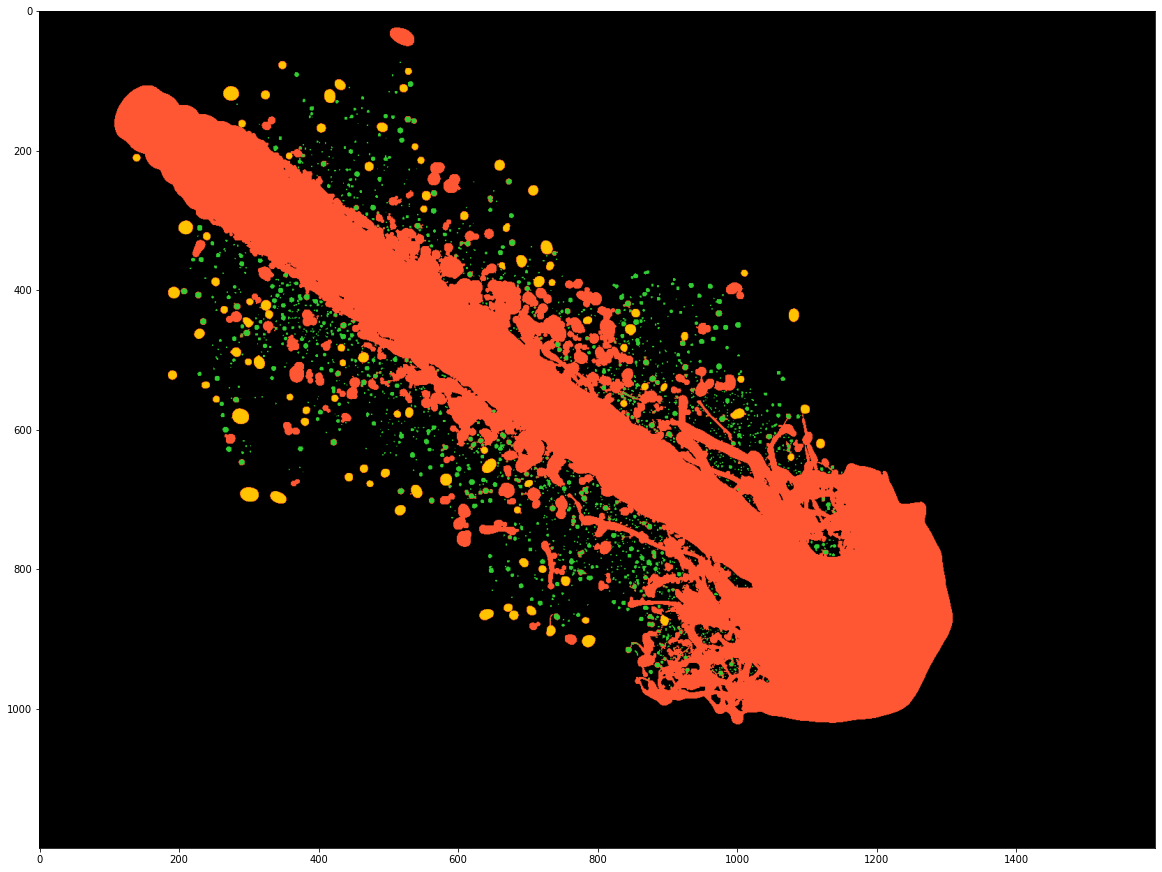

In [72]:
# https://www.geeksforgeeks.org/find-circles-and-ellipses-in-an-image-using-opencv-python/#:~:text=To%20identify%20circles%2C%20ellipses%2C%20or,SimpleBlobDetector()%20function%20of%20OpenCV.

# Hướng 2: dùng blob với các tiêu chí

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_mask, connectivity=4)

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = False
params.filterByInertia = False

params.filterByCircularity = True
params.minCircularity = 0.8

params.filterByConvexity = True
params.minConvexity = 0.96

detector = cv2.SimpleBlobDetector_create(params)

for k in range(1, retval):
    cc_mask = np.zeros_like(img_mask)
    cc_mask[labels == k] = 255

    loc = np.roll(np.where(labels == k), 1, axis=0).transpose().reshape(-1,2)
    keypoints = detector.detect(255 - cc_mask)
    if len(keypoints) == 1:
        points.append(loc)
        class_name.append('large drop')

        # sau khi đánh nhãn xong thì xóa đi
        img[labels == k] = 255
        img_gray[labels == k] = 255
        img_mask[labels == k] = 0

        ### chỉ để visualize
        xywha = cv2.minAreaRect(loc)
        xyxy = cv2.boxPoints(xywha).astype(np.int32)
        cv2.drawContours(vis_box, [xyxy], -1, YELLOW, 1)
        vis_seg[labels == k] = YELLOW


### chỉ để visualize
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_box, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(vis_seg, cv2.COLOR_BGR2RGB))
plt.show()
###

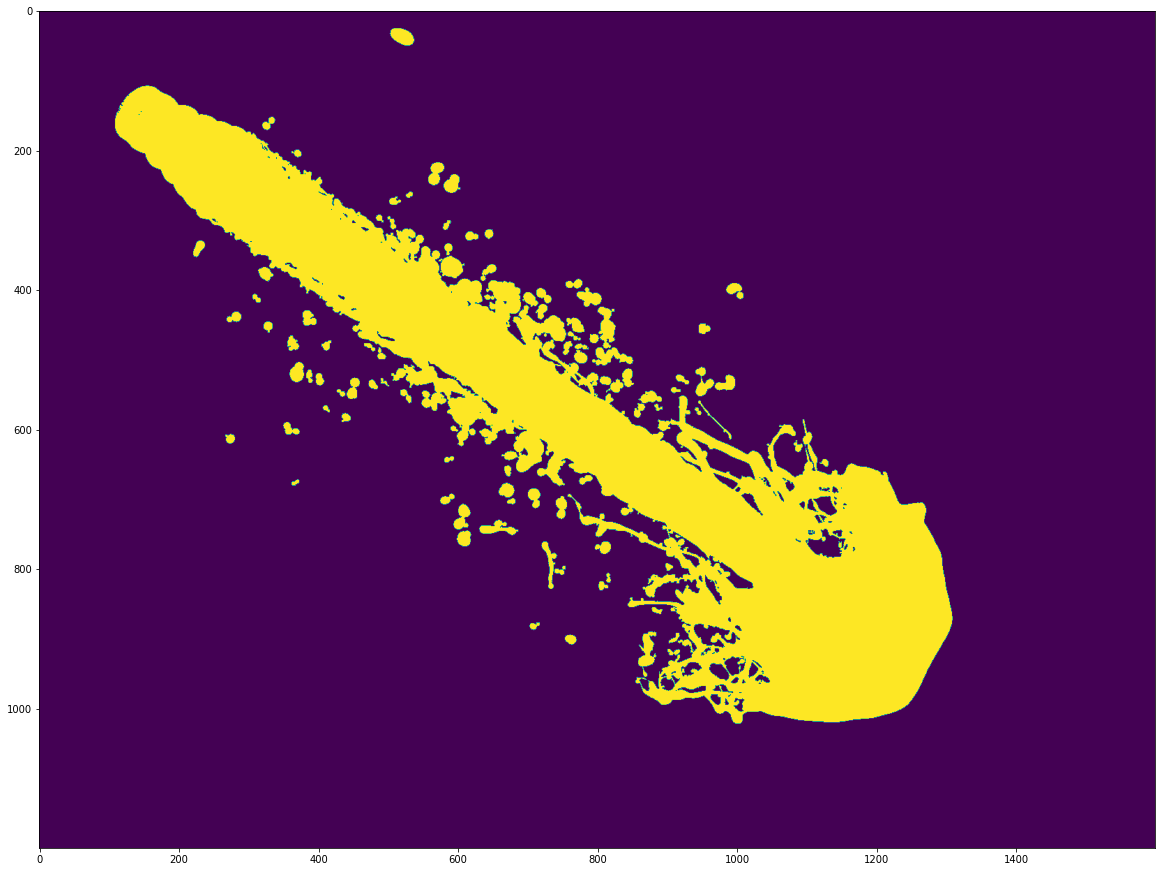

In [74]:
plt.figure(figsize=(20, 20))
plt.imshow(img_mask)

In [47]:
!convert -delay 20 -loop 0 1/demo*.png 1/myimage.gif

In [10]:
contours, hierarchy = cv2.findContours(
    image=thresh,
    mode=cv2.RETR_CCOMP,                        # RETR_LIST: NO relationship, RETR_EXTERNAL: ignores child contours, RETR_CCOMP: 2-level hierarchy
    method=cv2.CHAIN_APPROX_NONE                # CHAIN_APPROX_SIMPLE: compresses line segments and leaves only their end points
)                                               # hierarchy: [Next, Previous, First_Child, Parent]

# lọc chỉ lấy contour của level-1
contours = [contours[i] for i in range(len(contours)) if hierarchy[0][i][-1] == -1]
hierarchy = np.array([[hierarchy[0][i] for i in range(len(hierarchy[0])) if hierarchy[0][i][-1] == -1]])

# vẽ contour lên ảnh thresh
contour_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=contour_thresh,
    contours=contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=1,
    lineType=cv2.LINE_8
)

cv2.imwrite('1/contour_thresh.png', contour_thresh)


True

In [11]:
# area: 'm00'
# centroid cx: int(M['m10']/M['m00']), cy: int(M['m01']/M['m00'])
moments = [cv2.moments(cnt) for cnt in contours]
areas = [cv2.contourArea(cnt) for cnt in contours]

# the 2nd param specifies whether shape is a closed contour
perimeters = [cv2.arcLength(cnt, True) for cnt in contours]

In [12]:
# trích bounding box theo trục từ contour
# rectangles = [cv2.boundingRect(cnt) for cnt in contours]

# trích bounding box khớp nhất
rectangles = [cv2.minAreaRect(cnt) for cnt in contours]         # [(x, y), (w, h), angle_of_rotate]

# chuyển từ xywh sang xyxy
boxes = [cv2.boxPoints(rect).astype('int32') for rect in rectangles]

# aspect ratio
epsilon = 1
ratios = [np.exp(np.abs(np.log((rect[1][0] + epsilon) / (rect[1][1] + epsilon)))) for rect in rectangles]

thresh_boxes = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
cv2.drawContours(thresh_boxes, boxes, -1, (0, 195, 255), 1, cv2.LINE_4)
cv2.imwrite('1/thresh_boxes.png', thresh_boxes)

True

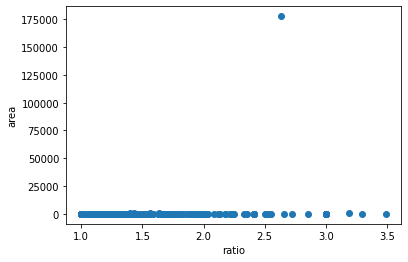

In [13]:
plt.scatter(ratios, areas)
plt.xlabel('ratio')
plt.ylabel('area')
plt.show()

In [14]:
# dùng luật về tỉ lệ và diện tích: README

img_arearatio = img.copy()
cv2.drawContours(img_arearatio, [boxes[i] for i in range(len(boxes)) if ratios[i] < 2.5 or areas[i] < 20], -1, (0, 195, 255), 1, cv2.LINE_4)
cv2.drawContours(img_arearatio, [boxes[i] for i in range(len(boxes)) if 2.5 <= ratios[i] and 20 <= areas[i]], -1, (51, 87, 255), 1, cv2.LINE_4)

cv2.imwrite('1/img_arearatio.png', img_arearatio)

True

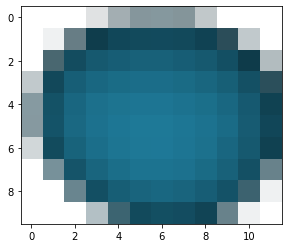

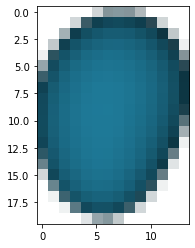

True

In [15]:
# dùng luật về moment (HuMoment, không phải nội dung như SIFT): README

# giot tròn: 1, 11, 12, 13, 19, 27, 34, 39, 44, 46, 50, 52, 59, 84, 94, 98
# giọt dài: 3, 10, 15, 18, 32,
idx_1 = 1
idx_2 = 3

# hiển thị ảnh của template
x1, y1, w, h = cv2.boundingRect(contours[idx_1])
drop = get_drops(img, [[x1, y1, x1 + w, y1 + h]])[0]
plt.imshow(cv2.cvtColor(drop, cv2.COLOR_BGR2RGB))
plt.show()
x1, y1, w, h = cv2.boundingRect(contours[idx_2])
drop = get_drops(img, [[x1, y1, x1 + w, y1 + h]])[0]
plt.imshow(cv2.cvtColor(drop, cv2.COLOR_BGR2RGB))
plt.show()

# tính độ khớp với mỗi template
ret_1 = [cv2.matchShapes(contours[idx_1], cnt, 1, 0.0) for cnt in contours]
ret_2 = [cv2.matchShapes(contours[idx_2], cnt, 1, 0.0) for cnt in contours]
img_matchshape_1 = img.copy()
maskout_1 = np.full_like(img, 255)

YELLOW = (0, 195, 255)
RED = (51, 87, 255)
GREEN = (50, 205, 50)

# mask_red = []
for i in range(len(boxes)):
    # vẽ contour màu vàng cho các drop, đồng thời tạo mask để tí lọc bỏ các drop này
    # có thể đánh nhãn luôn ở bước này
    if ret_1[i] < 0.16 or ret_2[i] < 0.16 or areas[i] < 10:
        cv2.drawContours(img_matchshape_1, [contours[i]], -1, YELLOW, 1, cv2.LINE_4)
        cv2.drawContours(maskout_1, [contours[i]], -1, 0, -1, cv2.LINE_4)
    else:
        # vẽ contour màu đỏ cho các trường hợp còn lại
        cv2.drawContours(img_matchshape_1, [contours[i]], -1, RED, 1, cv2.LINE_4)

        # # tạo riêng từng mask cho mỗi contour đó
        # tmask = np.zeros_like(img)
        # cv2.drawContours(tmask, [contours[i]], -1, (255, 255, 255), -1, cv2.LINE_4)
        # mask_red.append(tmask)


cv2.imwrite('1/img_matchshape_1.png', img_matchshape_1)
cv2.imwrite('1/maskout_1.png', maskout_1)

In [16]:
# visualize khoảng cách của 1 số giọt với template về shape
# sau khi chạy xong thì phải chạy lại các đoạn code bên trên do đã dùng chung tên biến

# rectangles = [cv2.boundingRect(cnt) for cnt in contours]
# for i in range(len(rectangles)):
#     x, y, w, h = rectangles[i]
#     x = x + int(w/2)
#     y = y + int(h/2)
#     rectangles[i] = (x, y, w, h)
# boxes = xywh_to_xyxy(rectangles)
# boxes = np.concatenate([np.array(boxes),
#                         np.expand_dims(np.array(ret_1), axis=-1), np.zeros((len(ret_1), 1))], axis=1)
# boxes = np.array([boxes[i] for i in range(len(boxes)) if areas[i] > 5])
# os.makedirs('1/rets', exist_ok=True)
# for _ in range(24):
#     indexes = np.random.choice(list(range(len(boxes))), 50)
#     sample_boxes = boxes[indexes]
#     temp_img = plot_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), boxes=sample_boxes, font_size=10)
#
#     cv2.imwrite(f'1/rets/{_}.png', cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))

In [17]:
# plt.figure(figsize=(20, 10))
# plt.hist(temp_ret_1, bins=len(temp_ret_1))
# plt.xlim([0, 2])
# plt.show()
# plt.figure(figsize=(20, 10))
# plt.hist(temp_ret_2, bins=len(temp_ret_1))
# plt.xlim([0, 2])
# plt.show()

In [18]:
# lọc bỏ các drop đã detect được
# chắc là chỉ có ích cho việc visualize kết quả

# sau bước lọc này sẽ để lại nhiễu
img_maskout_1 = np.full_like(img, 255)
img_maskout_1[maskout_1 == 255] = img[maskout_1 == 255]

# tạo mask lọc nhiễu bằng cách blur ảnh nhị phân
ret, thresh_maskout_1 = cv2.threshold(cv2.cvtColor(img_maskout_1, cv2.COLOR_BGR2GRAY), 254, 255, cv2.THRESH_BINARY_INV)
thresh_maskout_1_blur = cv2.medianBlur(thresh_maskout_1, 5)
img_maskout_1 = np.full_like(img, 255)
img_maskout_1[thresh_maskout_1_blur == 255] = img[thresh_maskout_1_blur == 255]

cv2.imwrite('1/img_maskout_1.png', img_maskout_1)
cv2.imwrite('1/thresh_maskout_1.png', thresh_maskout_1)

img_maskout_1_gray = cv2.cvtColor(img_maskout_1, cv2.COLOR_BGR2GRAY)
cv2.imwrite('1/img_maskout_1_gray.png', img_maskout_1_gray)

True

Giai đoạn 2

In [19]:
# KẾ THỪA:

os.makedirs('1/2', exist_ok=True)

# dùng lại tên biến cho tiện :-)
img = img_maskout_1
img_gray = img_maskout_1_gray

# cải thiện chất lượng ảnh gốc:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(60, 60 * 2))

# img_maskout_1 = cv2.cvtColor(img_maskout_1, cv2.COLOR_BGR2HLS)
# img_maskout_1[:, :, 1] = clahe.apply(img_maskout_1[:, :, 1])
# img_maskout_1 = cv2.cvtColor(img_maskout_1, cv2.COLOR_HLS2BGR)

img_gray = clahe.apply(img_gray)
cv2.imwrite('1/2/img_gray.png', img_gray)

True

In [109]:
ret, thresh = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite('1/2/thresh.png', thresh)

True

In [102]:
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
cv2.imwrite('1/2/img_blur.png', img_blur)

True

In [21]:
# # thử bộ lọc Sobel. Không tốt, tốt nhất là cặp (3, 1) cho img_gray

os.makedirs('1/2/edges', exist_ok=True)

for k in range(3, 20, 2):
    for d in range(1, k):

        edges = cv2.Sobel(img_blur, ddepth=cv2.CV_64F, dx=d, dy=d, ksize=k)
        cv2.imwrite(f'1/2/edges/{k}-{d}.png', edges)

In [110]:
# thử bộ lọc canny

os.makedirs('1/2/edges', exist_ok=True)

for t1 in range(100, 301, 25):
    for t2 in range(25, t1, 25):
        for k in range(3, 10, 2):
            for d in range(k):
                # img_blur = cv2.GaussianBlur(img_gray, (k, k), d)
                edges = cv2.Canny(thresh, t2, t1)
                cv2.imwrite(f'1/2/edges/{t1}-{t2}-{k}-{d}.png', edges)


In [111]:
# hough transform

dps = [1, 2, 3, 4, 5]
param1s = list(range(50, 301, 50))
param2s = np.arange(0.4, 5.2, 0.2)
maxRadiuss = [5, 10, 20]
os.makedirs('1/2/hough', exist_ok=True)
for dp in dps:
    for param1 in param1s:
        for param2 in param2s:
            for maxRadius in maxRadiuss:
                circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, dp, minDist=5, param1=param1, param2=param2, minRadius=1, maxRadius=maxRadius)
                circles = np.uint16(np.around(circles))

                img_hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
                for i in circles[0, :]:
                    cv2.circle(img_hough, (i[0], i[1]), i[2], (0, 195, 255), 1)
                    # cv2.circle(img_hough, (i[0], i[1]), 2, (0, 0, 255), 2)

                cv2.imwrite(f'1/2/hough/{dp}-{param1}-{param2}-{maxRadius}.png', img_hough)

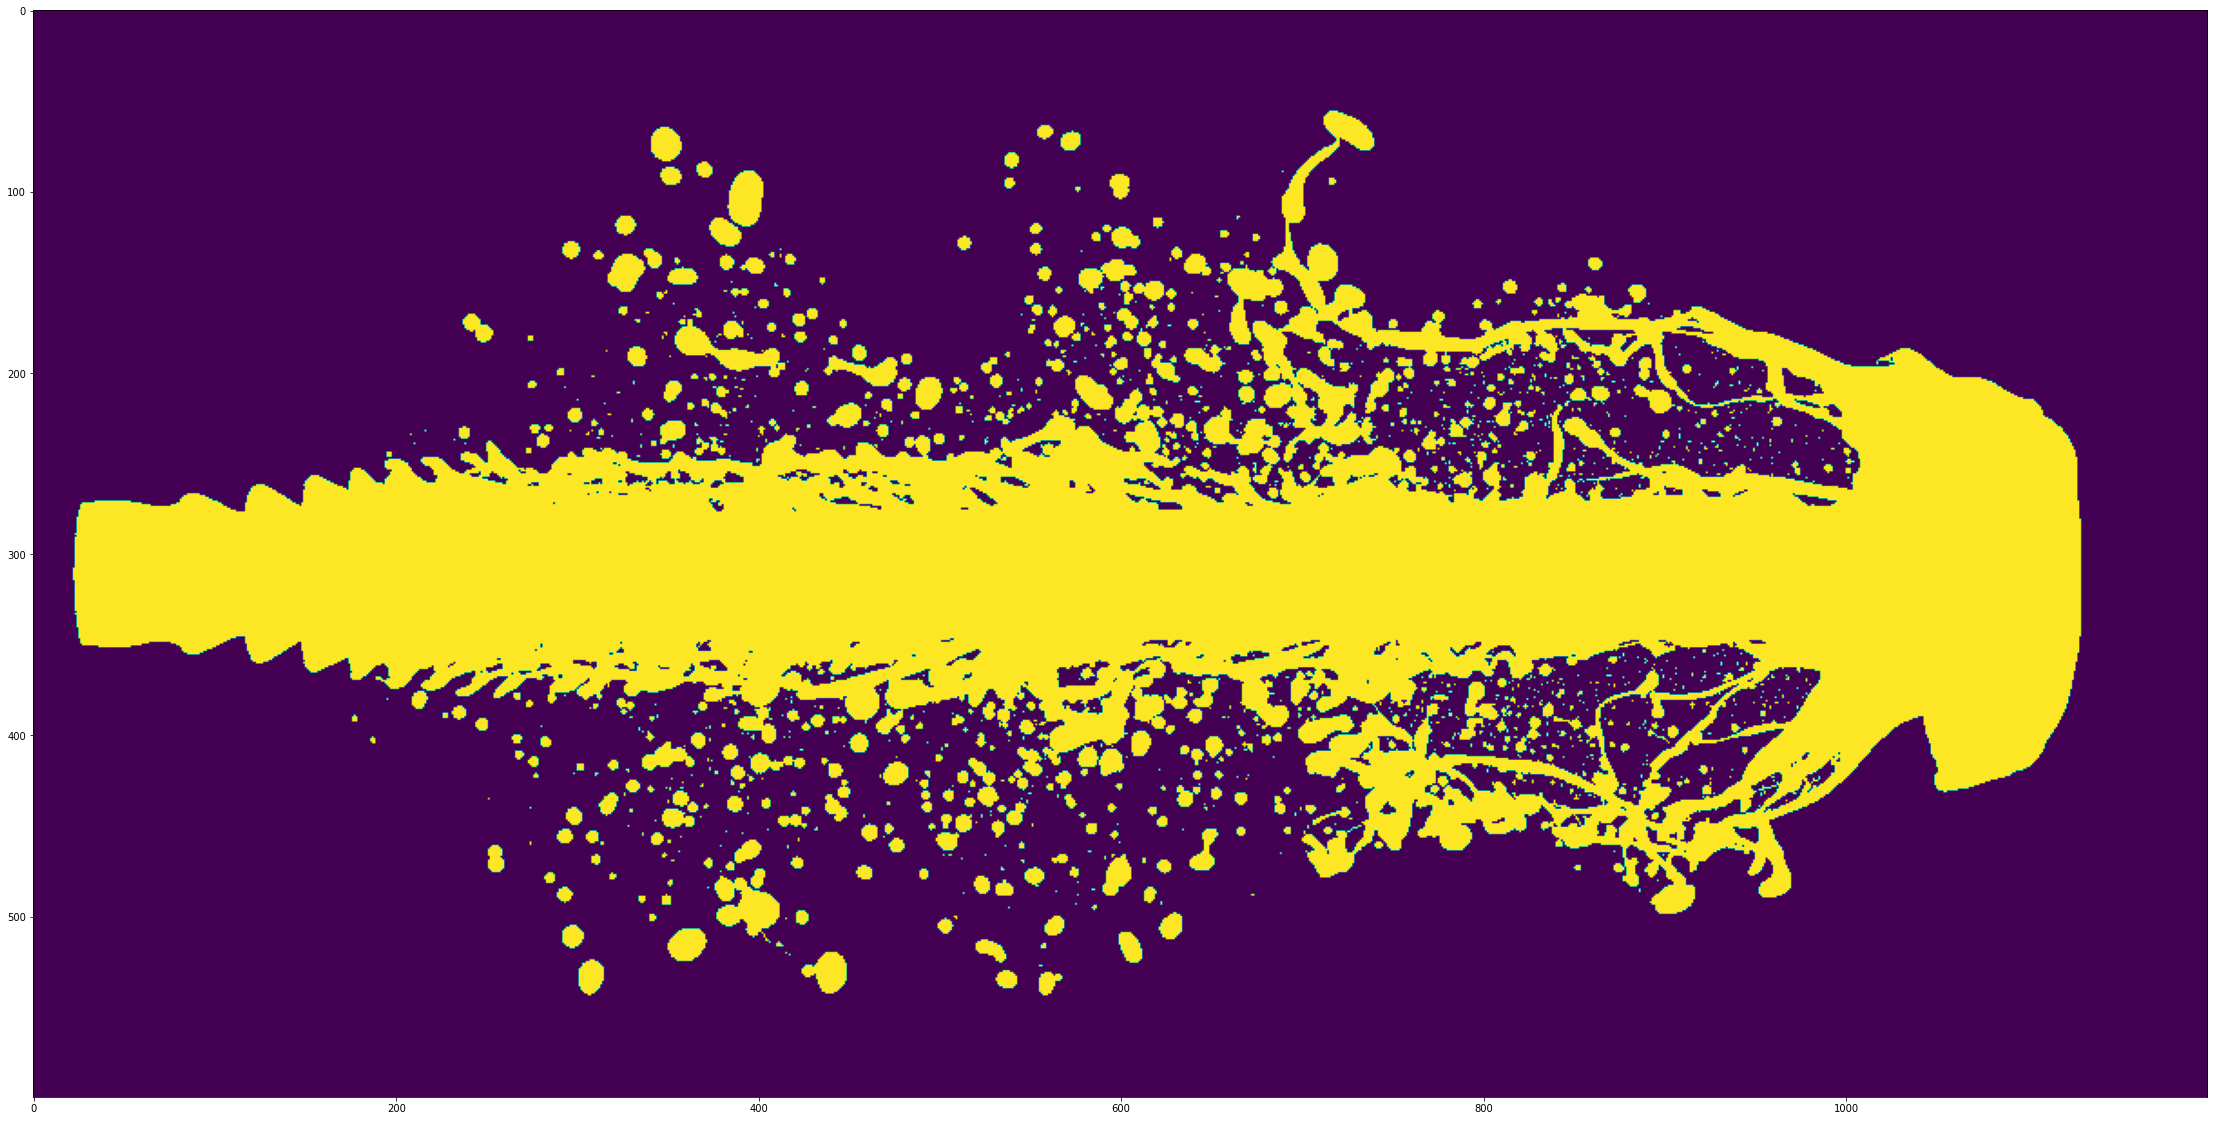

In [64]:
plt.figure(figsize=(40, 20))
plt.imshow(thresh)

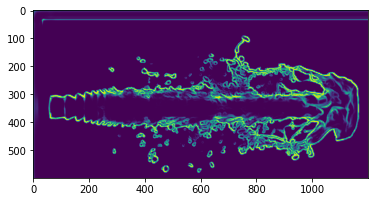

In [48]:
# H, W = img.shape[:2]
#
# blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(W, H), swapRB=False, crop=False)
#
# net = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'hed_pretrained_bsds.caffemodel')
#
# net.setInput(blob)
# hed = net.forward()
#
# hed = cv2.resize(hed[0, 0], (W, H))
# hed = (255 * hed).astype('uint8')

# plt.imshow(hed)

In [32]:
contours, hierarchy = cv2.findContours(
    image=255 - img_gray,
    mode=cv2.RETR_CCOMP,
    method=cv2.CHAIN_APPROX_NONE

)

# lọc chỉ lấy contour của level-1
contours = [contours[i] for i in range(len(contours)) if hierarchy[0][i][-1] == -1]
hierarchy = np.array([[hierarchy[0][i] for i in range(len(hierarchy[0])) if hierarchy[0][i][-1] == -1]])

# vẽ contour lên ảnh thresh
img_gray_copy = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=img_gray_copy,
    contours=contours,
    contourIdx=-1,
    color=(255, 255, 0),
    thickness=1,
    lineType=cv2.LINE_8
)

cv2.imwrite('1/2/img_gray_copy.png', img_gray_copy)

True

In [19]:
# Từ img_dropout_gray. Hướng 1: threshold đường biên mờ giữa các vật sát nhau.
# Cách này chưa thể tách được các vật overlap 1 phần mà
# chỉ có thể xử lý 2 vật ở gần nhau (có thể bị dính bởi nhiều pixel).
# //TODO: hiện tại đang dùng global nên chưa thể tách được hết 2 vật, thử dùng local xem sao
ret, img_x = cv2.threshold(255 - img_maskout_1_gray, 150, 255, cv2.THRESH_TOZERO)
img_x = 255 - img_x
# cv2.imwrite('img_x.png', img_x)

# kernel = np.array(
#     [[1, 0, 1],
#      [0, 1, 0],
#      [1, 0, 1]],
#     dtype=np.uint8
# )
kernel = np.ones((3, 3), np.uint8)

# Từ img_dropout_gray. Hướng 2: dilate:
# Nếu có 2 vật, thì có thể sẽ lấy được vật to hơn. Nếu 2 vật đủ to thì mới có thể lấy được 2 vật
# Nhưng có thể làm mất vật thuôn dài, hoặc làm 1 vật thuôn bị chia làm đôi
#  Nếu 2 vật nối với nhau bởi 1 pixel thì còn dễ, nếu nhiều pixel thì cạnh và vật sẽ hòa màu vào nhau khó phân biệt
dilation = cv2.dilate(img_maskout_1_gray, kernel, iterations=1)
cv2.imwrite('dilation.png', dilation)


ret, thresh_x = cv2.threshold(img_x, 254, 255, cv2.THRESH_BINARY_INV)
closing = cv2.morphologyEx(img_maskout_1_gray, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('closing.png', closing)
# erosion = cv2.erode(thresh_x, kernel, iterations=1)


True

In [ ]:
# xem histogram của ảnh gốc (bỏ hết background trắng)
plt.plot(cv2.calcHist([img_gray], [0], img_mask, [256], [0, 256]))      # cv.calcHist(imgs, channels, mask, bins, range)
plt.show()


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(60, 60 * 2))
img_clahe = clahe.apply(img_gray)
# cv2.imwrite('img_clahe.png', img_clahe)

# ret, img_x = cv2.threshold(255 - img_clahe, 150, 255, cv2.THRESH_TOZERO)
# img_x = 255 - img_x

plt.plot(cv2.calcHist([img_clahe], [0], img_mask, [256], [0, 256]))
plt.show()

ret, thresh_clahe = cv2.threshold(img_clahe, 210, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite('thresh_clahe.png', thresh_clahe)

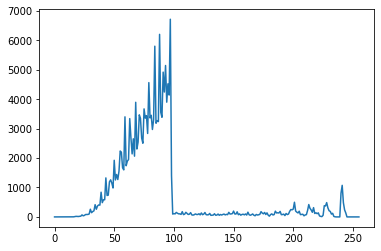

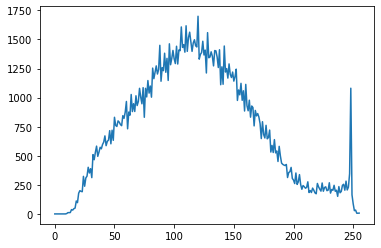

In [44]:
plt.plot(cv2.calcHist([img_gray],[0],thresh_dropout,[256],[0,256]))
plt.show()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(100, 200))
img_clahe = clahe.apply(img_dropout_gray)
cv2.imwrite('img_clahe.png', img_clahe)

################### các giọt liti: thử dùng outlier trên 1 cửa sổ?????????????

plt.plot(cv2.calcHist([img_clahe],[0],thresh_dropout,[256],[0,256]))
plt.show()

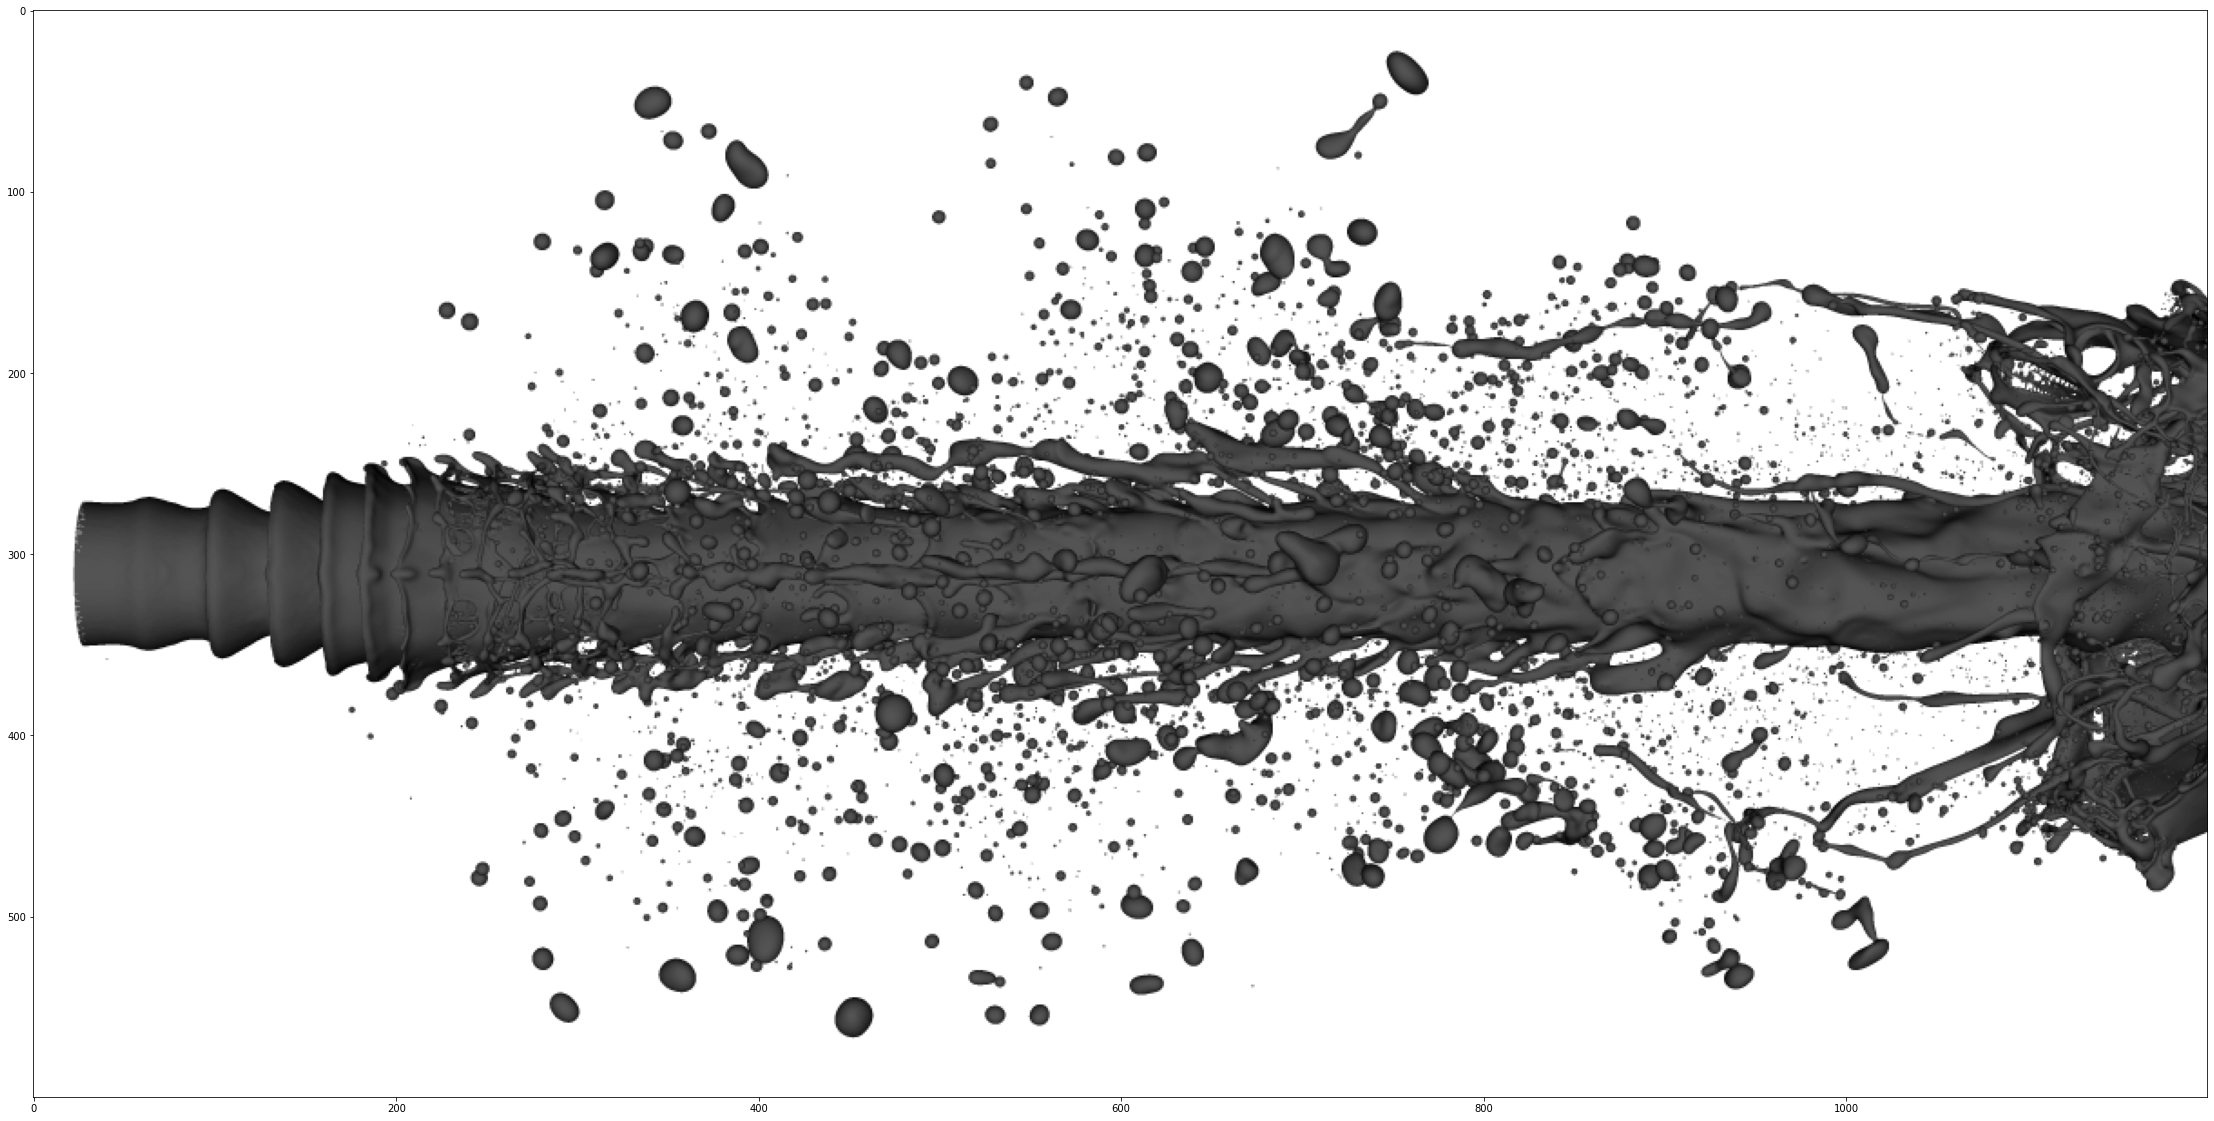

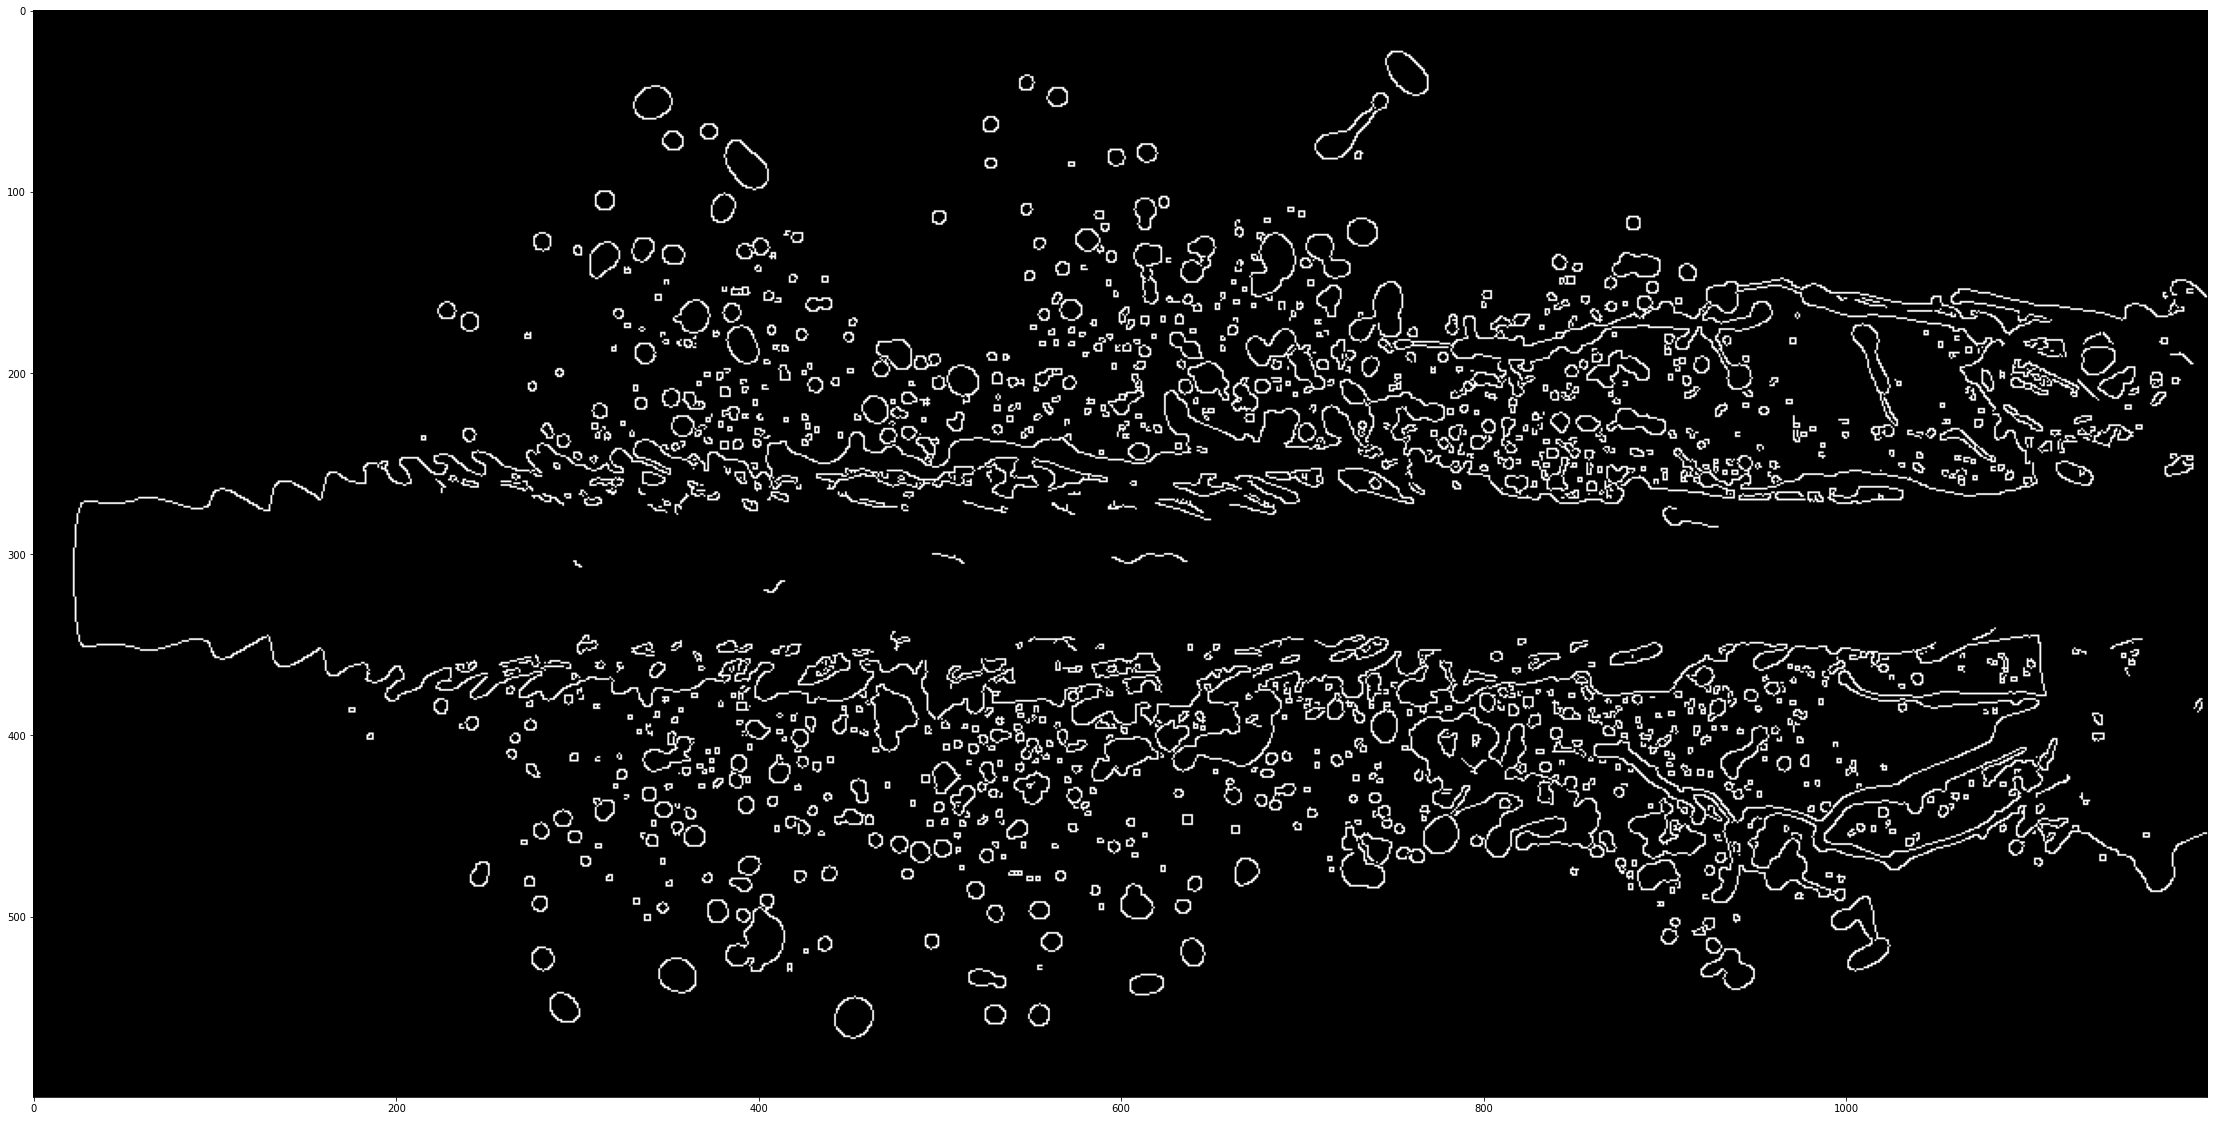

In [19]:
lbl_path = 'deepspray/data/data_1/labels/f_01495.txt'
img_path = lbl_path.replace('labels', 'images').replace('txt', 'png')

img = np.array(Image.open(img_path).convert('RGB'))

boxes = process_txt(lbl_path)
boxes = [box[1:] + box[:1] for box in boxes]
boxes = xywh_to_xyxy(yolo_to_coco(img.shape, boxes))

import cv2

# BGR
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # sao phải chuyển vể gray?
# blur ảnh để detect cạnh tốt hơn do thông thường trong ảnh có thể có nhiễu. Bilateral blur ảnh mà không làm blur cạnh
# Cách blur:
# https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
# https://learnopencv.com/image-filtering-using-convolution-in-opencv/
# * average: cv.blur(img,(5,5))
# * gaussian: cv.GaussianBlur(img,(5,5),0)      # stdX, same for stdY
# * median: cv.medianBlur(img,5)
# * bilateral: cv.bilateralFilter(img,9,75,75)  # tham số: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
# //TODO Nhưng mà ảnh này khá là chuẩn, không biết có nên blur không
# //TODO thử bộ lọc blur khác, điều chỉnh tham số của bộ lọc
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
# chi tiết: https://learnopencv.com/edge-detection-using-opencv/#canny-edge
# https://pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/


# plt.figure(figsize=(40, 20))
# plot_image(img)
# plt.show()
plt.figure(figsize=(40, 20))
plot_image(img_gray, cmap='gray')
plt.show()
# plt.figure(figsize=(40, 20))
# plot_image(img_blur, cmap='gray')
# plt.show()
plt.figure(figsize=(40, 20))
plot_image(edges, cmap='gray')
plt.show()